# MultiCamera Paper Results Generation and Plotting

# WARNING: WAYMO PROFILES ARE WITH DATADIST PREDICTION METRIC

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
from collections import defaultdict
import os
import json
import pandas as pd
import numpy as np

In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

from utilitysimv4 import Camera, InferenceJob, TrainingJob, MultiPeriodSimulator, fair_naive_scheduler, fair_dumb_scheduler, fair_sco_scheduler, fair_random_scheduler, inference_only_scheduler, single_camera_naive, get_optimus_fn, thief_sco_scheduler, single_camera_optimizer, get_tanh_fn, get_linear_fn, get_infer_profile, get_tanh_fn, simulator, thief_scheduler, fair_scheduler

In [3]:
PROFILE_DIR = '/home/romilb/research/msr/results/profiling/new_profiling/waymo/meta/profiles_datadist'
INFERENCE_PROFILE_PATH = '../real_inference_profiles.csv'
INFERENCE_MAX_DEFAULT = 0.25

In [4]:
def read_profiles(profile_dir, city_name, use_oracle = False):
    # use_oracle: Use oracle data instead of predictions
    profile_path = os.path.join(profile_dir, "{}.json".format(city_name))
    with open(profile_path) as f:
        data = json.load(f)
    offset = int(sorted(data["taskwise_train_profiles"], key=lambda x: int(x))[0])
    final_data = {"taskwise_train_profiles": {},
                  "taskwise_infer_profiles": {},
                  "taskwise_predicted_profiles": {}}
    for key in data["taskwise_train_profiles"].keys():
        final_data["taskwise_train_profiles"][str(int(key)-offset)] = data["taskwise_train_profiles"][key]
    for key in data["taskwise_infer_profiles"].keys():
        final_data["taskwise_infer_profiles"][str(int(key)-offset)] = data["taskwise_infer_profiles"][key]
    for key in data["taskwise_predicted_profiles"].keys():
        if use_oracle:
            final_data["taskwise_predicted_profiles"][str(int(key)-offset)] = data["taskwise_train_profiles"][key]
        else:
            final_data["taskwise_predicted_profiles"][str(int(key)-offset)] = data["taskwise_predicted_profiles"][key]
    assert "taskwise_train_profiles" in final_data
    assert "taskwise_infer_profiles" in final_data
    return final_data

def create_cameras(city_names, profile_dir = PROFILE_DIR, inference_max_resources = INFERENCE_MAX_DEFAULT, use_oracle = False):
    cameras = []
    print("Creating cameras for cities {}".format(city_names))
    for idx, city in enumerate(city_names):        
        data_pred = read_profiles(profile_dir, city, use_oracle)
        
        TASKS = data_pred["taskwise_train_profiles"].keys()
        # Format = [Acc, res_time, 0]
        train_profiles = {TASK_ID: [[x[2], x[3], 0] for x in data_pred["taskwise_predicted_profiles"][TASK_ID]] for TASK_ID in TASKS}
        
        # Format = [Acc, res_time, 0]
        oracle_profiles = {TASK_ID: [[x[2], x[3], 0] for x in data_pred["taskwise_train_profiles"][TASK_ID]] for TASK_ID in TASKS}
        
        # TODO: Picking min profile, which else can we pick?
        infer_start_accs = {TASK_ID: min([acc for hp_id, acc in data_pred["taskwise_infer_profiles"][TASK_ID].items()]) for TASK_ID in TASKS}

        cameras.append(Camera("{}_{}".format(city, idx),
                              train_profiles,
                              oracle_profiles,
                              infer_start_accs,
                              inference_profile_path=INFERENCE_PROFILE_PATH,
                              inference_max_resources=inference_max_resources
                             ))
    return cameras

# Cost vs accuracy - Multi Cam

In [5]:
def get_citywise_data(results, city):
    tasks = list(results.keys())
    tasks.remove('meta')
    final_data = None
    for task in tasks:
        for job in results[task].keys():
            if isinstance(job, InferenceJob):
                if city in job.name:
                    d = results[task][job]
                    time, acc = list(zip(*d))
                    data = pd.DataFrame(acc, columns=['task_{}'.format(task)], index=time)
                    data.index.name = 'time'
                    if final_data is None:
                        final_data = data
                    else:
                        final_data = final_data.join(data)
    return final_data

In [6]:
l=os.listdir(PROFILE_DIR)
cities=[x.split('.')[0] for x in l]
cities = cities*3 + ['phx-21-40']
print(cities)

['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']


In [ ]:
data = []
all_data = pd.DataFrame()
#cities = ["phx-21-40", "phx-41-60"]
INFER_MAX_RES = 0.25

periods_to_test = [100,200] #[10, 50, 100, 200, 400]
provisioned_res_to_test = [1,2,4,8]#np.arange(0,1,0.2)#,2,4,8,16]#,32,64]#[1,2,4,8,16]#list(np.arange(0,1,0.05))#
task_ids = [str(x) for x in range(1,6)]
use_oracle_modes = [True, False]

allocation = defaultdict(dict)
camera_names = cities

schedulers_to_test = [(fair_dumb_scheduler, 'fair_dumb'),
                     # (fair_naive_scheduler, 'fair_naive'),
                     (fair_sco_scheduler, 'fair_sco'),
                     (lambda x,y,z: thief_sco_scheduler(x,y,z,iterations=3,steal_increment=INFER_MAX_RES/3), 'thief'),
                     (inference_only_scheduler, 'inference_only')
                     ]

column_names = ['period', 'resources', 'use_oracle', *[sched_name for _, sched_name in schedulers_to_test]]
for retraining_period in periods_to_test:
    for provisioned_res in provisioned_res_to_test:
        for use_oracle in use_oracle_modes:
            this_config_result = [retraining_period, provisioned_res, use_oracle]
            for scheduler, sched_name in schedulers_to_test:
                print("Sched: {}, Resources: {}. Period: {}. Use_Oracle: {}.".format(
                    sched_name, provisioned_res, retraining_period, use_oracle))
                cameras = create_cameras(camera_names, inference_max_resources = INFER_MAX_RES, use_oracle=use_oracle)
                mps = MultiPeriodSimulator(cameras, provisioned_res, scheduler, retraining_period, task_ids = task_ids)
                results, period_allocation_log = mps.step_till_completion()
                
                #Get citywise data
                for city_alias in [c.name for c in cameras]:
                    d=get_citywise_data(results, city_alias)
                    d['city']=city_alias
                    d['res']=provisioned_res
                    d['period']=retraining_period
                    d['use_oracle']=use_oracle
                    d['sched'] = sched_name
                    all_data = pd.concat([all_data, d])
                
                this_config_result.append(results['meta']['overall_inf_mean_auc'])
                allocation["{}_{}_{}_{}".format(retraining_period, provisioned_res, sched_name, use_oracle)] = period_allocation_log
            data.append(this_config_result)
            df = pd.DataFrame(data, columns=column_names)
            df.to_csv('data_eval_multicam_waymo_datadist.csv')
            all_data.to_csv('data_eval_multicam_all_data_waymo_datadist.csv')
            
            with open('data_eval_multicam_allocationdata_waymo_datadist.json', 'w') as outfile:
                json.dump(allocation, outfile)

Sched: fair_dumb, Resources: 1. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1


50
100
Simulator steps done.
50
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-8

Running task 2


Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-

Running task 3


100
Simulator steps done.
50
100


Running task 4
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, ignoring profile phx-41-60_4_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, ignoring profile phx-41-60_7_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor 

Simulator steps done.
50
100
Simulator steps done.


Running task 5
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, ignoring profile sf-65-84_2_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, ignoring profile sf-65-84_5_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, ignoring profile sf-65-84_8_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, still adding profile if the predict

Job phx-41-60_1_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_

Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_4_train_32 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_32 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_32 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_4_train_32 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_32 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_32 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_4_train_32 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_32 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_3

Job phx-41-60_4_train_32 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_32 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_32 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_4_train_32 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_32 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_32 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_4_train_32 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_32 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_32 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_3

Running task 2


50
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-

Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_9 is

Running task 3


Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
50
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-

Job phx-21-40_9_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_

Running task 4
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, ignoring profile phx-41-60_4_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, ignoring profile phx-41-60_7_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor 

50
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-

Running task 5
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, ignoring profile sf-65-84_2_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, ignoring profile sf-65-84_5_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, ignoring profile sf-65-84_8_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, still adding profile if the predict

50
Job phx-41-60_1_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job phx-41-

Sched: thief, Resources: 1. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337c553d68>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cc384e0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c9864a8>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c89ee10>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cb63a58>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cac1518>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cc1c438>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cb77be0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337caa1908>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cba97b8>: [0.05, 0.05]}
Best config for phx-21-40_0_inference: phx-21-40_0_train_30
Best config fo

Job phx-41-60_1_train_31 is done.
Job phx-41-60_4_train_31 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_31 is done.
Job phx-41-60_1_train_31 is done.
Job phx-41-60_7_train_31 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_31 is done.
Job phx-41-60_1_train_31 is done.
Job phx-41-60_7_train_31 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_31 is done.
Job phx-41-60_1_train_31 is done.
Job phx-41-60_7_train_31 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_31 is done.
Job phx-41-60_1_train_31 is done.
Job phx-41-60_7_train_31 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_31 is done.
Job phx-41-60_1_train_31 is done.
Job phx-41-60_7_train_31 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_31 is done.
Job phx-41-60_1_train_31 is done.
Job phx-41-60_7_train_31 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_31 is done.
Job phx-41-60_1_train_31 is done.
Job phx-41-60_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c553d68>: [0.05, 0.0666666666666667], <utilitysimv4.InferenceJob object at 0x7f337cc384e0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c9864a8>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c89ee10>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cb63a58>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cac1518>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cc1c438>: [0.05, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f337cb77be0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337caa1908>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cba97b8>: [0.05, 0.05]}


Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_31 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_31 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_1_train_31 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_31 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_31 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_1_train_31 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_31 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_31 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_1_train_31 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_31 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_31 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_1_train_31 is done.
Job phx-21-40_3_train_30 is done.
50
Job phx-21-40_6_train_30 is done.
Job phx-41-

Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_31 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_31 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_1_train_31 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_31 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_31 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_1_train_31 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_31 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_31 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_1_train_31 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_trai

Job phx-21-40_3_train_30 is done.
Simulator steps done.


Running task 2
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337c553d68>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cc384e0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c9864a8>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c89ee10>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cb63a58>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cac1518>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cc1c438>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cb77be0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337caa1908>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cba97b8>: [0.05, 0.05]}
Best config for phx-21-40_0_inference: phx-21-40_0_train_30
Best config for phx-41-60_1_inference: phx-41-60_1_train_36
Best config for sf-65-84_2_inference: sf-65-84_2_train_30
Best config for phx-21-40_3_inference: phx-21-40_3_train_30
Best config for phx-41-60_4_inference: phx-41-60_4_

Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 i

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c553d68>: [0.05, 0.033333333333333354], <utilitysimv4.InferenceJob object at 0x7f337cc384e0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c9864a8>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c89ee10>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cb63a58>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cac1518>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cc1c438>: [0.05, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f337cb77be0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337caa1908>: [0.05, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f337cba97b8>: [0.05, 0.05]}


Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_1

Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_

Running task 3
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337c553d68>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cc384e0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c9864a8>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c89ee10>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cb63a58>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cac1518>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cc1c438>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cb77be0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337caa1908>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cba97b8>: [0.05, 0.05]}
Best config for phx-21-40_0_inference: phx-21-40_0_train_30
Best config for phx-41-60_1_inference: phx-41-60_1_train_36
Best config for sf-65-84_2_inference: sf-65-84_2_train_30
Best config for phx-21-40_3_inference: phx-21-40_3_train_30
Best config for phx-41-60_4_inference: phx-41-60_4_

Job phx-21-40_3_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c553d68>: [0.05, 0.0666666666666667], <utilitysimv4.InferenceJob object at 0x7f337cc384e0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c9864a8>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c89ee10>: [0.05, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f337cb63a58>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cac1518>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cc1c438>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cb77be0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337caa1908>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cba97b8>: [0.05, 0.05]}


Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_

Job phx-41-60_7_train_36 is done.
Job sf-65-84_5_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_5_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_5_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_5_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_tr

Running task 4
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, ignoring profile phx-41-60_4_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, ignoring profile phx-41-60_7_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor 

Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c553d68>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cc384e0>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c9864a8>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c89ee10>: [0.05, 0.13333333333333336], <utilitysimv4.InferenceJob object at 0x7f337cb63a58>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cac1518>: [0.05, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cc1c438>: [0.05, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f337cb77be0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337caa1908>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cba97b8>: [0.05, 0.13333333333333333]}


Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_5_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_5_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_5_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_5_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_5_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_5_train_30 is done.
Job phx-21-40_3_trai

Job phx-41-60_7_train_36 is done.
Job sf-65-84_5_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_5_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_5_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_5_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_5_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30

Running task 5
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, ignoring profile sf-65-84_2_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, ignoring profile sf-65-84_5_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, ignoring profile sf-65-84_8_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, still adding profile if the predict

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.923333333333333
 ACTUAL: 0.923333333333333
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9233333333333335
 ACTUAL: 0.9233333333333335
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9233333333333335
 ACTUAL: 0.9233333333333335
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9233333333333336
 ACTUAL: 0.9233333333333336
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9500000000000003
 ACTUAL: 0.9500000000000003
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9500000000000002
 ACTUAL: 0.9500000000000002
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9589743589743591
 ACTUAL: 0.9589743589743591
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9589743589743591
 ACTUAL: 0.9589743589743591
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0

Job phx-21-40_3_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.953846153846154
 ACTUAL: 0.953846153846154
 DESIRED: 1
Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c553d68>: [0.05, 0.0666666666666667], <utilitysimv4.InferenceJob object at 0x7f337cc384e0>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c9864a8>: [0.05, 0.08333333333333336], <utilitysimv4.InferenceJob object at 0x7f337c89ee10>: [0.05, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f337cb63a58>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cac1518>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cc1c438>: [0.05, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f337cb77be0>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f337caa1908>: [0.0, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cba97

Job phx-21-40_6_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_18 is done.
Job sf-65-84_2_train_30 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_18 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_18 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_18 is done.
50
Job sf-65-84_2_train_30 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_18 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_3_t

Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_18 is done.
Job sf-65-84_2_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_18 is done.
Job sf-65-84_2_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_18 is done.
Job sf-65-84_2_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_18 is done.
Job sf-65-84_2_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_18 is done.
Job sf-65-84_2_train_30 is done.
Job sf-65-84_8_train_30

Sched: inference_only, Resources: 1. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1


50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 2
Running task 3


50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 4
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, ignoring profile phx-41-60_4_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, ignoring profile phx-41-60_7_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor 

50
100
Simulator steps done.


Sched: fair_dumb, Resources: 1. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1


50
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-

Running task 2


Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_

Running task 3


Simulator steps done.
50
100


Running task 4
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor decides to use it..


Simulator steps done.
50
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_3

Running task 5
WARNING(predictedcfg): Final accuracy 0.5766677712652486 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_13.
WARNING(predictedcfg): Final accuracy 0.5581260485056853 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_16.
WARNING(predictedcfg): Final accuracy 0.5656908228569062 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_17.
WARNING(predictedcfg): Final accuracy 0.5156421514818881 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(predictedcfg): Final accuracy 0.5488991984756539 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_52.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNI

Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_

Sched: fair_sco, Resources: 1. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1


Job phx-41-60_1_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_

Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_1

Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_3

Running task 2


50
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx

Running task 3


50
Job phx-21-40_0_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx

Job phx-21-40_9_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_2_train_18 is done

Running task 4
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor decides to use it..


50
Job phx-41-60_1_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_30 is d

Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_0_train_30 is done

Running task 5
WARNING(predictedcfg): Final accuracy 0.5766677712652486 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_13.
WARNING(predictedcfg): Final accuracy 0.5581260485056853 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_16.
WARNING(predictedcfg): Final accuracy 0.5656908228569062 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_17.
WARNING(predictedcfg): Final accuracy 0.5156421514818881 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(predictedcfg): Final accuracy 0.5488991984756539 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_52.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNI

50
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_0_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_0_train_36 is done.
Job phx-41-

Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_0_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_0_train_36 is done.
100
Job phx-41-60_7_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_0_train_36 is done.
Simulator steps done.


Sched: thief, Resources: 1. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337cab67f0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cca9b00>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c50f898>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cb77e80>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c93b438>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cab6898>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c7e8ef0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cb919b0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cbc79b0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cab6d30>: [0.05, 0.05]}
Best config for phx-21-40_0_inference: phx-21-40_0_train_30
Best config f

Job phx-41-60_1_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337cab67f0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cca9b00>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c50f898>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cb77e80>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c93b438>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cab6898>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c7e8ef0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cb919b0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cbc79b0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cab6d30>: [0.05, 0.05]}


Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_30 is done.
50
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-

Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_3

Job phx-41-60_1_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_8_train_18 is done.
100
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_tra

Running task 2
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337cab67f0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cca9b00>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c50f898>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cb77e80>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c93b438>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cab6898>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c7e8ef0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cb919b0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cbc79b0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cab6d30>: [0.05, 0.05]}
Best config for phx-21-40_0_inference: phx-21-40_0_train_30
Best config for phx-41-60_1_inference: phx-41-60_1_train_36
Best config for sf-65-84_2_inference: sf-65-84_2_train_18
Best config for phx-21-40_3_inference: phx-21-40_3_train_30
Best config for phx-41-60_4_inference: phx-41-60_4_

Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job p

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337cab67f0>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cca9b00>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c50f898>: [0.05, 0.13333333333333336], <utilitysimv4.InferenceJob object at 0x7f337cb77e80>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c93b438>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cab6898>: [0.05, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f337c7e8ef0>: [0.05, 0.08333333333333333], <utilitysimv4.InferenceJob object at 0x7f337cb919b0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cbc79b0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cab6d30>: [0.05, 0.05]}


Job phx-41-60_7_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_2_train_18 is d

Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
100
Job phx-21-40_6_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Simulator steps done.


Running task 3
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337cab67f0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cca9b00>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c50f898>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cb77e80>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c93b438>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cab6898>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c7e8ef0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cb919b0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cbc79b0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cab6d30>: [0.05, 0.05]}
Best config for phx-21-40_0_inference: phx-21-40_0_train_30
Best config for phx-41-60_1_inference: phx-41-60_1_train_36
Best config for sf-65-84_2_inference: sf-65-84_2_train_30
Best config for phx-21-40_3_inference: phx-21-40_3_train_30
Best config for phx-41-60_4_inference: phx-41-60_4_

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9541666666666663
 ACTUAL: 0.9541666666666663
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9541666666666663
 ACTUAL: 0.9541666666666663
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9541666666666663
 ACTUAL: 0.9541666666666663
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9541666666666663
 ACTUAL: 0.9541666666666663
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9541666666666663
 ACTUAL: 0.9541666666666663
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9541666666666663
 ACTUAL: 0.9541666666666663
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9541666666666663
 ACTUAL: 0.9541666666666663
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9541666666666663
 ACTUAL: 0.9541666666666663
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9541666666666663
 ACTUAL: 0.9541666666666663
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9541666666666663
 ACTUAL: 0.9541666666666663
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9541666666666663
 ACTUAL: 0.9541666666666663
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9541666666666663
 ACTUAL: 0.9541666666666663
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9541666666666663
 ACTUAL: 0.9541666666666663
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9541666666666663
 ACTUAL: 0.9541666666666663
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

Job phx-41-60_7_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337cab67f0>: [0.0, 0.0666666666666667], <utilitysimv4.InferenceJob object at 0x7f337cca9b00>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c50f898>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cb77e80>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c93b438>: [0.05, 0.11666666666666668], <utilitysimv4.InferenceJob object at 0x7f337cab6898>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c7e8ef0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cb919b0>: [0.05, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f337cbc79b0>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cab6d30>: [0.05, 0.08333333333333333]}


Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_

Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_

Running task 4
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor decides to use it..
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337cab67f0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cca9b00>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c50f898>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cb77e80>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c93b438>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cab6898>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x

Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337cab67f0>: [0.05, 0.08333333333333334], <utilitysimv4.InferenceJob object at 0x7f337cca9b00>: [0.05, 0.08333333333333333], <utilitysimv4.InferenceJob object at 0x7f337c50f898>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cb77e80>: [0.05, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c93b438>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cab6898>: [0.0, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c7e8ef0>: [0.05, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f337cb919b0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cbc79b0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cab6d30>: [0.05, 0.05]}


Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_

Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_

Running task 5
WARNING(predictedcfg): Final accuracy 0.5766677712652486 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_13.
WARNING(predictedcfg): Final accuracy 0.5581260485056853 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_16.
WARNING(predictedcfg): Final accuracy 0.5656908228569062 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_17.
WARNING(predictedcfg): Final accuracy 0.5156421514818881 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(predictedcfg): Final accuracy 0.5488991984756539 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_52.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNI

Best config for phx-21-40_0_inference: phx-21-40_0_train_36
Best config for phx-41-60_1_inference: phx-41-60_1_train_0
Best config for sf-65-84_2_inference: sf-65-84_2_train_30
Best config for phx-21-40_3_inference: phx-21-40_3_train_36
Best config for phx-41-60_4_inference: phx-41-60_4_train_0
Best config for sf-65-84_5_inference: sf-65-84_5_train_0
Best config for phx-21-40_6_inference: phx-21-40_6_train_36
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for sf-65-84_8_inference: sf-65-84_8_train_30
Best config for phx-21-40_9_inference: phx-21-40_9_train_36
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9583333333333334
 ACTUAL: 0.9583333333333334
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9583333333333334
 ACTUAL: 0.9583333333333334
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9583333333333334
 ACTUAL: 0.9583333333333334
 DESIRED: 1
WARNINGG

Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337cab67f0>: [0.05, 0.13333333333333336], <utilitysimv4.InferenceJob object at 0x7f337cca9b00>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c50f898>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cb77e80>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c93b438>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cab6898>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c7e8ef0>: [0.05, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f337cb919b0>: [0.05, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cbc79b0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cab6d30>: [0.05, 0.13333333333333333]}


Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_

Sched: inference_only, Resources: 1. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1


50
100
Simulator steps done.
50
100
Simulator steps done.
50


Running task 2
Running task 3


100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 4
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor decides to use it..
Running task 5
WARNING(predictedcfg): Final accuracy 0.5766677712652486 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_13.
WARNING(predictedcfg): Final accuracy 0.5581260485056853 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_16.
WARNING(predictedcfg): Final accuracy 0.5656908228569062 less than current acc 0.6668346774193549 for camera phx-41-60_1, igno

50
Job sf-65-84_2_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job phx

Running task 2


Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-

Running task 3


Job phx-21-40_3_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_9_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_9_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_9_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_9_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_9_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_9_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_9_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21

Running task 4
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, ignoring profile phx-41-60_4_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, ignoring profile phx-41-60_7_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor 

Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_

Running task 5
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, ignoring profile sf-65-84_2_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, ignoring profile sf-65-84_5_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, ignoring profile sf-65-84_8_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, still adding profile if the predict

Job phx-41-60_4_train_25 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job phx-41-60_7_train_25 is done.
100
Job phx-41-60_1_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job phx-41-60_7_train_25 is done.
Simulator steps done.


Sched: fair_sco, Resources: 2. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1


Job phx-41-60_1_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_

Job phx-41-60_1_train_32 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_32 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_7_train_32 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_32 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_32 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_7_train_32 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_32 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_32 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_7_train_32 is done.
Job phx-21-40_9_train_9 is done.
J

Job phx-21-40_6_train_9 is done.
Job phx-41-60_7_train_32 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_32 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_32 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_7_train_32 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_32 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_32 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_7_train_32 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_32 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_32 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
J

Job phx-21-40_3_train_9 is done.
Job sf-65-84_5_train_18 is done.
100
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_7_train_32 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_32 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_32 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_5_train_18 is done.
Simulator steps done.


Running task 2


Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_t

Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 i

Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_9 is done.
100
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_9 is done.
Simulator steps done.


Running task 3


Job phx-21-40_0_train_18 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_

Job phx-21-40_9_train_18 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_

Job phx-21-40_6_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_9_train_18 is done.
100
Job phx-21-40_3_train_18 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_9_train_18 is done.
Simulator steps done.


Running task 4
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, ignoring profile phx-41-60_4_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, ignoring profile phx-41-60_7_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor 

Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_

Job sf-65-84_5_train_19 is done.
Job phx-21-40_6_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job sf-65-84_8_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_5_train_19 is done.
Job phx-21-40_6_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job sf-65-84_8_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_5_train_19 is done.
Job phx-21-40_6_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job sf-65-84_8_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_3

Running task 5
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, ignoring profile sf-65-84_2_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, ignoring profile sf-65-84_5_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, ignoring profile sf-65-84_8_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, still adding profile if the predict

50
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 

Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_24 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_24 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_24 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_24 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 i

Sched: thief, Resources: 2. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337cb24e80>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cc79160>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337ccca630>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c457b70>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c9c8048>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337ccd1748>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cb822e8>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cc9e518>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cad1be0>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c92ff98>: [0.1, 0.1]}
Best config for phx-21-40_0_inference: phx-21-40_0_train_30
Best config for phx-41-60_1_infere

Job phx-21-40_9_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337cb24e80>: [0.0, 0.13333333333333341], <utilitysimv4.InferenceJob object at 0x7f337cc79160>: [0.0, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f337ccca630>: [0.05000000000000003, 0.18333333333333332], <utilitysimv4.InferenceJob object at 0x7f337c457b70>: [0.0, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f337c9c8048>: [0.0, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f337ccd1748>: [0.033333333333333354, 0.35], <utilitysimv4.InferenceJob object at 0x7f337cb822e8>: [0.0, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cc9e518>: [0.0, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cad1be0>: [0.033333333333333354, 0.36666666666666664], <utilitysimv4.InferenceJob object at 0x7f337c92ff98>: [0.0, 0.35]}


Job phx-41-60_4_train_37 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_3

Job phx-41-60_1_train_37 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_2_train_1

Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_3

Running task 2
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337cb24e80>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cc79160>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337ccca630>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c457b70>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c9c8048>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337ccd1748>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cb822e8>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cc9e518>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cad1be0>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c92ff98>: [0.1, 0.1]}
Best config for phx-21-40_0_inference: phx-21-40_0_train_30
Best config for phx-41-60_1_inference: phx-41-60_1_train_36
Best config for sf-65-84_2_inference: sf-65-84_2_train_18
Best config for phx-21-40_3_inference: phx-21-40_3_train_30
Best config for phx-41-60_4_inference: phx-41-60_4_train_36
Best config

Job phx-21-40_9_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_1

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337cb24e80>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cc79160>: [0.0, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f337ccca630>: [0.0, 0.13333333333333336], <utilitysimv4.InferenceJob object at 0x7f337c457b70>: [0.1, 0.18333333333333335], <utilitysimv4.InferenceJob object at 0x7f337c9c8048>: [0.033333333333333354, 0.1], <utilitysimv4.InferenceJob object at 0x7f337ccd1748>: [0.0, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cb822e8>: [0.1, 0.2], <utilitysimv4.InferenceJob object at 0x7f337cc9e518>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cad1be0>: [0.08333333333333333, 0.30000000000000004], <utilitysimv4.InferenceJob object at 0x7f337c92ff98>: [0.1, 0.26666666666666666]}


Job phx-41-60_1_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 

Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_36 

Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_0 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_0 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_0 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_18 i

Running task 3
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337cb24e80>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cc79160>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337ccca630>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c457b70>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c9c8048>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337ccd1748>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cb822e8>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cc9e518>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cad1be0>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c92ff98>: [0.1, 0.1]}
Best config for phx-21-40_0_inference: phx-21-40_0_train_30
Best config for phx-41-60_1_inference: phx-41-60_1_train_36
Best config for sf-65-84_2_inference: sf-65-84_2_train_30
Best config for phx-21-40_3_inference: phx-21-40_3_train_30
Best config for phx-41-60_4_inference: phx-41-60_4_train_36
Best config

Job phx-21-40_0_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337cb24e80>: [0.1, 0.13333333333333341], <utilitysimv4.InferenceJob object at 0x7f337cc79160>: [0.1, 0.18333333333333335], <utilitysimv4.InferenceJob object at 0x7f337ccca630>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c457b70>: [0.1, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f337c9c8048>: [0.1, 0.18333333333333335], <utilitysimv4.InferenceJob object at 0x7f337ccd1748>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cb822e8>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cc9e518>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cad1be0>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c92ff98>: [0.1, 0.1]}


Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_t

Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_tr

Job phx-21-40_9_train_30 is done.
100
Job phx-41-60_7_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_30 is done.
Simulator steps done.


Running task 4
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, ignoring profile phx-41-60_4_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, ignoring profile phx-41-60_7_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor 

Best config for phx-21-40_6_inference: phx-21-40_6_train_18
Best config for phx-41-60_7_inference: phx-41-60_7_train_36
Best config for sf-65-84_8_inference: sf-65-84_8_train_30
Best config for phx-21-40_9_inference: phx-21-40_9_train_30
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8787037037037035
 ACTUAL: 1.8787037037037035
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.757407407407408
 ACTUAL: 1.757407407407408
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.757407407407408
 ACTUAL: 1.757407407407408
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.757407407407407
 ACTUAL: 1.757407407407407
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.7574074074074075
 ACTUAL: 1.7574074074074075
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.7574074074074078
 ACT

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8787037037037035
 ACTUAL: 1.8787037037037035
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.7574074074074078
 ACTUAL: 1.7574074074074078
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.757407407407407
 ACTUAL: 1.757407407407407
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.7574074074074075
 ACTUAL: 1.7574074074074075
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.7574074074074078
 ACTUAL: 1.7574074074074078
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8787037037037035
 ACTUAL: 1.8787037037037035
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.757407407407408
 ACTUAL: 1.757407407407408
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

Best config for phx-21-40_9_inference: phx-21-40_9_train_18


Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337cb24e80>: [0.1, 0.13333333333333341], <utilitysimv4.InferenceJob object at 0x7f337cc79160>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337ccca630>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c457b70>: [0.1, 0.21666666666666667], <utilitysimv4.InferenceJob object at 0x7f337c9c8048>: [0.1, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f337ccd1748>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cb822e8>: [0.1, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f337cc9e518>: [0.1, 0.18333333333333335], <utilitysimv4.InferenceJob object at 0x7f337cad1be0>: [0.08333333333333333, 0.11666666666666668], <utilitysimv4.InferenceJob object at 0x7f337c92ff98>: [0.1, 0.1]}


Job phx-21-40_9_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_18 is done.
Job phx-41-60_1_tr

Job sf-65-84_8_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_3_tr

Running task 5
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, ignoring profile sf-65-84_2_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, ignoring profile sf-65-84_5_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, ignoring profile sf-65-84_8_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, still adding profile if the predict

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9166666666666667
 ACTUAL: 1.9166666666666667
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9166666666666667
 ACTUAL: 1.9166666666666667
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9166666666666667
 ACTUAL: 1.9166666666666667
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9166666666666667
 ACTUAL: 1.9166666666666667
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9166666666666667
 ACTUAL: 1.9166666666666667
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9166666666666667
 ACTUAL: 1.9166666666666667
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9166666666666667
 ACTUAL: 1.9166666666666667
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9083333333333339
 ACTUAL: 1.9083333333333339
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9083333333333339
 ACTUAL: 1.9083333333333339
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9083333333333339
 ACTUAL: 1.9083333333333339
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9083333333333339
 ACTUAL: 1.9083333333333339
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9083333333333339
 ACTUAL: 1.9083333333333339
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9083333333333339
 ACTUAL: 1.9083333333333339
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9083333333333339
 ACTUAL: 1.9083333333333339
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

Job phx-21-40_9_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_3_train_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337cb24e80>: [0.1, 0.15000000000000002], <utilitysimv4.InferenceJob object at 0x7f337cc79160>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f337ccca630>: [0.1, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f337c457b70>: [0.1, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f337c9c8048>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f337ccd1748>: [0.1, 0.18333333333333335], <utilitysimv4.InferenceJob object at 0x7f337cb822e8>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cc9e518>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cad1be0>: [0.1, 0.18333333333333335], <utilitysimv4.InferenceJob object at 0x7f337c92ff98>: [0.1, 0.18333333333333335]}


Job phx-21-40_9_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_6_train_18 i

Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_18 is

Sched: inference_only, Resources: 2. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1


50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 2
Running task 3


50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 4
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, ignoring profile phx-41-60_4_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, ignoring profile phx-41-60_7_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor 

50
100
Simulator steps done.


Sched: fair_dumb, Resources: 2. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1


Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_

Job phx-41-60_4_train_49 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job phx-41-60_1_train_49 is done.
Job phx-41-60_4_train_49 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job phx-41-60_1_train_49 is done.
Job phx-41-60_4_train_49 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job phx-41-60_1_train_49 is done.
Job phx-41-60_4_train_49 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job phx-41-60_1_train_49 is done.
Job phx-41-60_4_train_49 is done.
Job phx-21-40_

Running task 2


Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_

Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Simulator steps done.
50


Running task 3


Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-

Running task 4
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor decides to use it..


50
100
Simulator steps done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_tra

Running task 5
WARNING(predictedcfg): Final accuracy 0.5766677712652486 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_13.
WARNING(predictedcfg): Final accuracy 0.5581260485056853 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_16.
WARNING(predictedcfg): Final accuracy 0.5656908228569062 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_17.
WARNING(predictedcfg): Final accuracy 0.5156421514818881 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(predictedcfg): Final accuracy 0.5488991984756539 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_52.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNI

Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_

Sched: fair_sco, Resources: 2. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1


Job phx-41-60_1_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_

Job phx-41-60_1_train_30 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_2_train_3 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_2_train_3 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_2_train_3 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done

Job phx-21-40_9_train_36 is done.
Job sf-65-84_2_train_3 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_2_train_3 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_2_train_3 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_6_train_36 is done

Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_2_train_3 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_2_train_3 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_2_train_3 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_3_train_36 is done

Running task 2


Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_18 is done.


Job phx-41-60_4_train_27 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_27 is done.
Job phx-41-60_7_train_27 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_27 is done.
Job phx-41-60_7_train_27 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_27 is done.
Job phx-41-60_7_train_27 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_3

Job phx-41-60_7_train_27 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_27 is done.
Job phx-41-60_7_train_27 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_27 is done.
Job phx-41-60_7_train_27 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_2

Running task 3


Job phx-21-40_0_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21

Job phx-41-60_4_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job sf-65-84_8_train_18 is done.
J

Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
J

Running task 4
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor decides to use it..


Job phx-41-60_1_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41

Job phx-41-60_1_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41

Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41

Running task 5
WARNING(predictedcfg): Final accuracy 0.5766677712652486 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_13.
WARNING(predictedcfg): Final accuracy 0.5581260485056853 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_16.
WARNING(predictedcfg): Final accuracy 0.5656908228569062 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_17.
WARNING(predictedcfg): Final accuracy 0.5156421514818881 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(predictedcfg): Final accuracy 0.5488991984756539 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_52.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNI

Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_

Job sf-65-84_8_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job sf-65-84_5_train_19 is done.
Job phx-41-60_4_train_51 is done.
Job phx-41-60_7_train_51 is done.
Job sf-65-84_8_train_19 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_51 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_2_train_19 is done.
Job sf-65-84_5_train_19 is done.
Job phx-41-60_4_train_51 is done.
Job phx-41-60_7_train_51 is done.
Job sf-65-84_8_train_19 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_51 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_2_train_19 is done.
Job sf-65-84_5_train_19 is done.
Job phx-41-60_4_train_51 is done.
Job phx-41-60_7_train_51 is done.
Job sf-65-84_8_train_19 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_51

Sched: thief, Resources: 2. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337c6a6ba8>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c6a9dd8>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c9e17b8>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c82e080>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cba6588>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c6a6e10>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cbfee10>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c5be9e8>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cba3f98>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c94ffd0>: [0.1, 0.1]}
Best config for phx-21-40_0_inference: phx-21-40_0_train_36
Best config for phx-41-60_1_infer

Job phx-41-60_4_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_tra

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c6a6ba8>: [0.0, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f337c6a9dd8>: [0.0, 0.04999999999999995], <utilitysimv4.InferenceJob object at 0x7f337c9e17b8>: [0.0, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c82e080>: [0.0, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f337cba6588>: [0.016666666666666677, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f337c6a6e10>: [0.016666666666666677, 0.44999999999999996], <utilitysimv4.InferenceJob object at 0x7f337cbfee10>: [0.0, 0.16666666666666669], <utilitysimv4.InferenceJob object at 0x7f337c5be9e8>: [0.0, 0.2], <utilitysimv4.InferenceJob object at 0x7f337cba3f98>: [0.0, 0.18333333333333335], <utilitysimv4.InferenceJob object at 0x7f337c94ffd0>: [0.0, 0.18333333333333335]}


Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_36 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_36 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_36 is done.
Job phx-41-60_4_train_3

Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_36 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_36 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_36 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_3

Job phx-21-40_0_train_36 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_36 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_36 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_1

Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_36 is done.
100
Job phx-41-60_4_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_36 is done.
Simulator steps done.


Running task 2
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337c6a6ba8>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c6a9dd8>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c9e17b8>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c82e080>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cba6588>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c6a6e10>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cbfee10>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c5be9e8>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cba3f98>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c94ffd0>: [0.1, 0.1]}
Best config for phx-21-40_0_inference: phx-21-40_0_train_30
Best config for phx-41-60_1_inference: phx-41-60_1_train_36
Best config for sf-65-84_2_inference: sf-65-84_2_train_18
Best config for phx-21-40_3_inference: phx-21-40_3_train_30
Best config for phx-41-60_4_inference: phx-41-60_4_train_36
Best config

Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job 

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c6a6ba8>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c6a9dd8>: [0.1, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f337c9e17b8>: [0.1, 0.15000000000000008], <utilitysimv4.InferenceJob object at 0x7f337c82e080>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cba6588>: [0.1, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f337c6a6e10>: [0.1, 0.18333333333333335], <utilitysimv4.InferenceJob object at 0x7f337cbfee10>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c5be9e8>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cba3f98>: [0.1, 0.18333333333333335], <utilitysimv4.InferenceJob object at 0x7f337c94ffd0>: [0.1, 0.18333333333333335]}


Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 i

Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is

Running task 3
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337c6a6ba8>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c6a9dd8>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c9e17b8>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c82e080>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cba6588>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c6a6e10>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cbfee10>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c5be9e8>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cba3f98>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c94ffd0>: [0.1, 0.1]}
Best config for phx-21-40_0_inference: phx-21-40_0_train_30
Best config for phx-41-60_1_inference: phx-41-60_1_train_36
Best config for sf-65-84_2_inference: sf-65-84_2_train_18
Best config for phx-21-40_3_inference: phx-21-40_3_train_30
Best config for phx-41-60_4_inference: phx-41-60_4_train_36
Best config

Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c6a6ba8>: [0.016666666666666677, 0.11666666666666668], <utilitysimv4.InferenceJob object at 0x7f337c6a9dd8>: [0.08333333333333333, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f337c9e17b8>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c82e080>: [0.016666666666666677, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f337cba6588>: [0.016666666666666677, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f337c6a6e10>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cbfee10>: [0.1, 0.18333333333333335], <utilitysimv4.InferenceJob object at 0x7f337c5be9e8>: [0.1, 0.18333333333333335], <utilitysimv4.InferenceJob object at 0x7f337cba3f98>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c94ffd0>: [0.1, 0.18333333333333335]}


Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_

Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_3

Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_1

Running task 4
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor decides to use it..
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337c6a6ba8>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c6a9dd8>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c9e17b8>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c82e080>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cba6588>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c6a6e10>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cbfee10

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8787037037037044
 ACTUAL: 1.8787037037037044
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8787037037037044
 ACTUAL: 1.8787037037037044
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8787037037037038
 ACTUAL: 1.8787037037037038
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8787037037037044
 ACTUAL: 1.8787037037037044
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8787037037037044
 ACTUAL: 1.8787037037037044
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8787037037037038
 ACTUAL: 1.8787037037037038
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8787037037037044
 ACTUAL: 1.8787037037037044
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

Best config for phx-21-40_0_inference: phx-21-40_0_train_0
Best config for phx-41-60_1_inference: phx-41-60_1_train_30
Best config for sf-65-84_2_inference: sf-65-84_2_train_18
Best config for phx-21-40_3_inference: phx-21-40_3_train_30
Best config for phx-41-60_4_inference: phx-41-60_4_train_30
Best config for sf-65-84_5_inference: sf-65-84_5_train_18
Best config for phx-21-40_6_inference: phx-21-40_6_train_30
Best config for phx-41-60_7_inference: phx-41-60_7_train_30
Best config for sf-65-84_8_inference: sf-65-84_8_train_18
Best config for phx-21-40_9_inference: phx-21-40_9_train_30
Iter 1, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c6a6ba8>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c6a9dd8>: [0.1, 0.11666666666666667], <utilitysimv4.InferenceJob object at 0x7f337c9e17b8>: [0.033333333333333354, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f337c82e080>: [0.1, 0.18333333333333335], <utilitysimv4.InferenceJob object at 0x7f337cba6588>: [0

Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_tr

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c6a6ba8>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c6a9dd8>: [0.1, 0.11666666666666668], <utilitysimv4.InferenceJob object at 0x7f337c9e17b8>: [0.1, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f337c82e080>: [0.1, 0.13333333333333336], <utilitysimv4.InferenceJob object at 0x7f337cba6588>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c6a6e10>: [0.1, 0.18333333333333335], <utilitysimv4.InferenceJob object at 0x7f337cbfee10>: [0.1, 0.18333333333333335], <utilitysimv4.InferenceJob object at 0x7f337c5be9e8>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337cba3f98>: [0.1, 0.1], <utilitysimv4.InferenceJob object at 0x7f337c94ffd0>: [0.1, 0.18333333333333335]}


Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 

Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_30 

Running task 5
WARNING(predictedcfg): Final accuracy 0.5766677712652486 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_13.
WARNING(predictedcfg): Final accuracy 0.5581260485056853 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_16.
WARNING(predictedcfg): Final accuracy 0.5656908228569062 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_17.
WARNING(predictedcfg): Final accuracy 0.5156421514818881 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(predictedcfg): Final accuracy 0.5488991984756539 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_52.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNI

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9222222222222218
 ACTUAL: 1.9222222222222218
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9222222222222218
 ACTUAL: 1.9222222222222218
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.922222222222222
 ACTUAL: 1.922222222222222
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.922222222222222
 ACTUAL: 1.922222222222222
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.922222222222222
 ACTUAL: 1.922222222222222
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9222222222222218
 ACTUAL: 1.9222222222222218
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.922222222222222
 ACTUAL: 1.922222222222222
 DESIRED: 2
Iter 1, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c6a6

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9138888888888892
 ACTUAL: 1.9138888888888892
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9152777777777779
 ACTUAL: 1.9152777777777779
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9138888888888894
 ACTUAL: 1.9138888888888894
 DESIRED: 2


Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c6a6ba8>: [0.1, 0.06666666666666671], <utilitysimv4.InferenceJob object at 0x7f337c6a9dd8>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c9e17b8>: [0.1, 0.1833333333333334], <utilitysimv4.InferenceJob object at 0x7f337c82e080>: [0.1, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f337cba6588>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c6a6e10>: [0.1, 0.2], <utilitysimv4.InferenceJob object at 0x7f337cbfee10>: [0.1, 0.18333333333333335], <utilitysimv4.InferenceJob object at 0x7f337c5be9e8>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cba3f98>: [0.08333333333333333, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f337c94ffd0>: [0.1, 0.18333333333333335]}


Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is

Job sf-65-84_8_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_30 is done.
Job sf-65-84_2_train_18 is 

Sched: inference_only, Resources: 2. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1


50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 2
Running task 3


50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 4
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor decides to use it..
Running task 5
WARNING(predictedcfg): Final accuracy 0.5766677712652486 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_13.
WARNING(predictedcfg): Final accuracy 0.5581260485056853 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_16.
WARNING(predictedcfg): Final accuracy 0.5656908228569062 less than current acc 0.6668346774193549 for camera phx-41-60_1, igno

50
100
Simulator steps done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_1_train_45 is done.
Job phx-41-60_4_train_45 is done.
Job phx-41-60_7_train_45 is done.
Job phx-41-60_7_train_45 is done.
Job phx-41-60_4_train_45 is done.
Job sf-65-84_2_train_39 is done.
Job phx-41-60_1_train_45 is done.


Sched: fair_dumb, Resources: 4. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1


Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_7_train_45 is done.
Job phx-41-60_4_train_45 is done.
Job sf-65-84_2_train_39 is done.
Job phx-41-60_1_train_45 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_7_train_45 is done.
Job phx-41-60_4_train_45 is done.
Job sf-65-84_2_train_39 is done.
Job phx-41-60_1_train_45 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_7_train_45 is done.
Job phx-41-60_4_train_45 is done.
Job sf-65-84_2_train_39 is done.
Job phx-41-60_1_train_45 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_7_train_45 is done.
Job phx-41-60_4_train_45 is done.
Job sf-65-84_2_train_39 is done.
Job phx-41-60_1_train_45 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_7_train_45 is done.
Job phx-41-60_4_train_45 is done.
Job sf-65-84_2_train_39 is done.
Job phx-41-60_1_train_45 is d

Job phx-41-60_1_train_45 is done.
Job phx-21-40_9_train_13 is done.
Job phx-21-40_0_train_13 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job phx-21-40_6_train_13 is done.
Job phx-21-40_3_train_13 is done.
Job phx-41-60_7_train_45 is done.
Job phx-41-60_4_train_45 is done.
Job sf-65-84_2_train_39 is done.
Job phx-41-60_1_train_45 is done.
Job phx-21-40_9_train_13 is done.
Job phx-21-40_0_train_13 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job phx-21-40_6_train_13 is done.
Job phx-21-40_3_train_13 is done.
Job phx-41-60_7_train_45 is done.
Job phx-41-60_4_train_45 is done.
Job sf-65-84_2_train_39 is done.
Job phx-41-60_1_train_45 is done.
Job phx-21-40_9_train_13 is done.
Job phx-21-40_0_train_13 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job phx-21-40_6_train_13 is done.
Job phx-21-40_3_train_13 is done.
Job phx-41-60_7_train_45 is done.
Job phx-41-60_4_train_45 is done.
Job sf-65-84_2_train_3

Running task 2


Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-

Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-

Running task 3


Job phx-21-40_9_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_9_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_6_train_4 is done.
50
Job phx-21-40_9_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_9_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_9_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_9_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_9_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_9_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx

Job phx-21-40_3_train_4 is done.
Job phx-41-60_1_train_15 is done.
Job phx-41-60_7_train_15 is done.
Job phx-21-40_9_train_4 is done.
Job sf-65-84_8_train_11 is done.
Job phx-41-60_4_train_15 is done.
Job phx-21-40_0_train_4 is done.
Job sf-65-84_2_train_11 is done.
Job sf-65-84_5_train_11 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-41-60_1_train_15 is done.
Job phx-41-60_7_train_15 is done.
Job phx-21-40_9_train_4 is done.
Job sf-65-84_8_train_11 is done.
Job phx-41-60_4_train_15 is done.
Job phx-21-40_0_train_4 is done.
Job sf-65-84_2_train_11 is done.
Job sf-65-84_5_train_11 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-41-60_1_train_15 is done.
Job phx-41-60_7_train_15 is done.
Job phx-21-40_9_train_4 is done.
Job sf-65-84_8_train_11 is done.
Job phx-41-60_4_train_15 is done.
Job phx-21-40_0_train_4 is done.
Job sf-65-84_2_train_11 is done.
Job sf-65-84_5_train_11 is done.
Job phx-21-40_6_train_4 is done.
J

Running task 4
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, ignoring profile phx-41-60_4_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, ignoring profile phx-41-60_7_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor 

Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
50
Job phx-21-40_6_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-

Job phx-41-60_1_train_25 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job sf-65-84_2_train_19 is done.
Job sf-65-84_5_train_19 is done.
Job sf-65-84_8_train_19 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job sf-65-84_8_train_19 is done.
Job sf-65-84_5_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job sf-65-84_8_train_19 is done.
Job sf-65-84_5_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job sf-65-84_8_train_19 is done.
Job sf-65-84_5_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job sf-65-84_8_train_19 is done.
Job sf-65-84_5_train_19 is done.
Job sf-65-84_2_train_19 is d

Running task 5
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, ignoring profile sf-65-84_2_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, ignoring profile sf-65-84_5_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, ignoring profile sf-65-84_8_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, still adding profile if the predict

Job phx-41-60_4_train_25 is done.
Job sf-65-84_8_train_19 is done.
Job sf-65-84_5_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job sf-65-84_8_train_19 is done.
Job sf-65-84_5_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job sf-65-84_8_train_19 is done.
Job sf-65-84_5_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job sf-65-84_8_train_19 is done.
Job sf-65-84_5_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job sf-65-84_8_train_19 is done.
Job sf-65-84_5_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is d

Simulator steps done.


Sched: fair_sco, Resources: 4. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1


Job phx-41-60_1_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_

Job sf-65-84_8_train_39 is done.
Job phx-41-60_4_train_32 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_2_train_39 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_32 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_1_train_32 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_8_train_39 is done.
Job phx-41-60_4_train_32 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_2_train_39 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_32 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_1_train_32 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_8_train_39 is done.
Job phx-41-60_4_train_32 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_2_train_39 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_32 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_1_train_32 is done.
Job phx-21-40_3_train_9 is done.
J

Job phx-41-60_7_train_32 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_1_train_32 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_8_train_39 is done.
Job phx-41-60_4_train_32 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_2_train_39 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_32 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_1_train_32 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_8_train_39 is done.
Job phx-41-60_4_train_32 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_2_train_39 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_32 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_1_train_32 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_8_train_39 is done.
Job phx-41-60_4_train_32 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_2_train_39 is done.
Job phx-21-40_0_train_9 is done.
J

Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_2_train_39 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_32 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_1_train_32 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_8_train_39 is done.
Job phx-41-60_4_train_32 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_2_train_39 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_32 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_1_train_32 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_8_train_39 is done.
Job phx-41-60_4_train_32 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_2_train_39 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_32 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_1_train_32 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_8_train_39 is done.
Job phx-41-60_4_train_32 is done.
J

Running task 2


Job phx-21-40_0_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41

Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21

Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21

Best config for phx-21-40_9_inference: phx-21-40_9_train_30
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337caee080>: [0.0, 0.11666666666666668], <utilitysimv4.InferenceJob object at 0x7f337c4c5be0>: [0.0, 0.2833333333333333], <utilitysimv4.InferenceJob object at 0x7f337cbad710>: [0.06666666666666671, 0.033333333333333326], <utilitysimv4.InferenceJob object at 0x7f337c5be6d8>: [0.0, 0.2833333333333333], <utilitysimv4.InferenceJob object at 0x7f337c6d2780>: [0.11666666666666668, 0.7833333333333333], <utilitysimv4.InferenceJob object at 0x7f337c7dda58>: [0.11666666666666668, 0.7833333333333332], <utilitysimv4.InferenceJob object at 0x7f337c6abe10>: [0.033333333333333354, 0.3166666666666667], <utilitysimv4.InferenceJob object at 0x7f337cba3080>: [0.06666666666666671, 0.5333333333333333], <utilitysimv4.InferenceJob object at 0x7f337c3bfd68>: [0.033333333333333354, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c96d7f0>: [0.033333333333333354, 0.2]}
Iter 1, alloc: {<uti

Job phx-41-60_7_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_1_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_37 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_37 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_37 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_37 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_t

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337caee080>: [0.0, 0.06666666666666671], <utilitysimv4.InferenceJob object at 0x7f337c4c5be0>: [0.06666666666666671, 0.16666666666666663], <utilitysimv4.InferenceJob object at 0x7f337cbad710>: [0.033333333333333354, 0.2833333333333334], <utilitysimv4.InferenceJob object at 0x7f337c5be6d8>: [0.0, 0.0666666666666668], <utilitysimv4.InferenceJob object at 0x7f337c6d2780>: [0.033333333333333354, 0.20000000000000004], <utilitysimv4.InferenceJob object at 0x7f337c7dda58>: [0.06666666666666671, 0.2833333333333334], <utilitysimv4.InferenceJob object at 0x7f337c6abe10>: [0.08333333333333333, 0.2833333333333333], <utilitysimv4.InferenceJob object at 0x7f337cba3080>: [0.11666666666666668, 0.7833333333333333], <utilitysimv4.InferenceJob object at 0x7f337c3bfd68>: [0.11666666666666668, 0.2833333333333333], <utilitysimv4.InferenceJob object at 0x7f337c96d7f0>: [0.11666666666666668, 0.95]}


Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_37 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_37 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_37 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_3

Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_37 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_37 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_37 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_3

Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_37 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_37 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_3

Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_37 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_37 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_37 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_9_train_3

Running task 2
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337caee080>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c4c5be0>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337cbad710>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c5be6d8>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c6d2780>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c7dda58>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c6abe10>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337cba3080>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c3bfd68>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c96d7f0>: [0.2, 0.2]}
Best config for phx-21-40_0_inference: phx-21-40_0_train_30
Best config for phx-41-60_1_inference: phx-41-60_1_train_9
Best config for sf-65-84_2_inference: sf-65-84_2_train_18
Best config for phx-21-40_3_inference: phx-21-40_3_train_30
Best config for phx-41-60_4_inference: phx-41-60_4_train_9
Best config f

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.2631578947368425
 ACTUAL: 3.2631578947368425
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.2631578947368425
 ACTUAL: 3.2631578947368425
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.2631578947368425
 ACTUAL: 3.2631578947368425
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.2631578947368425
 ACTUAL: 3.2631578947368425
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.263157894736843
 ACTUAL: 3.263157894736843
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.263157894736842
 ACTUAL: 3.263157894736842
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.2631578947368434
 ACTUAL: 3.2631578947368434
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

Best config for phx-21-40_0_inference: phx-21-40_0_train_0
Best config for phx-41-60_1_inference: phx-41-60_1_train_36
Best config for sf-65-84_2_inference: sf-65-84_2_train_18
Best config for phx-21-40_3_inference: phx-21-40_3_train_30
Best config for phx-41-60_4_inference: phx-41-60_4_train_0
Best config for sf-65-84_5_inference: sf-65-84_5_train_18
Best config for phx-21-40_6_inference: phx-21-40_6_train_30
Best config for phx-41-60_7_inference: phx-41-60_7_train_36
Best config for sf-65-84_8_inference: sf-65-84_8_train_18
Best config for phx-21-40_9_inference: phx-21-40_9_train_30
Iter 1, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337caee080>: [0.08333333333333333, 0.15000000000000002], <utilitysimv4.InferenceJob object at 0x7f337c4c5be0>: [0.11666666666666668, 0.20000000000000007], <utilitysimv4.InferenceJob object at 0x7f337cbad710>: [0.11666666666666668, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c5be6d8>: [0.11666666666666668, 0.16666666666666666], <utilitysi

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.2631578947368425
 ACTUAL: 3.2631578947368425
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.2631578947368425
 ACTUAL: 3.2631578947368425
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.2631578947368425
 ACTUAL: 3.2631578947368425
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.263157894736842
 ACTUAL: 3.263157894736842
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.263157894736843
 ACTUAL: 3.263157894736843
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.263157894736842
 ACTUAL: 3.263157894736842
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.2631578947368434
 ACTUAL: 3.2631578947368434
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

Job sf-65-84_5_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is d

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337caee080>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c4c5be0>: [0.033333333333333354, 0.15000000000000002], <utilitysimv4.InferenceJob object at 0x7f337cbad710>: [0.033333333333333354, 0.7], <utilitysimv4.InferenceJob object at 0x7f337c5be6d8>: [0.033333333333333354, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c6d2780>: [0.11666666666666668, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c7dda58>: [0.11666666666666668, 0.8666666666666666], <utilitysimv4.InferenceJob object at 0x7f337c6abe10>: [0.06666666666666665, 0.45], <utilitysimv4.InferenceJob object at 0x7f337cba3080>: [0.11666666666666668, 0.11666666666666667], <utilitysimv4.InferenceJob object at 0x7f337c3bfd68>: [0.033333333333333354, 0.31666666666666676], <utilitysimv4.InferenceJob object at 0x7f337c96d7f0>: [0.08333333333333333, 0.3666666666666667]}


Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done

Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_9 is done.
50
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_8_train_18 is d

Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done

Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_9 is done.
100
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_9 is done.
Simulator steps done.


Running task 3
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337caee080>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c4c5be0>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337cbad710>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c5be6d8>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c6d2780>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c7dda58>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c6abe10>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337cba3080>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c3bfd68>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c96d7f0>: [0.2, 0.2]}
Best config for phx-21-40_0_inference: phx-21-40_0_train_30
Best config for phx-41-60_1_inference: phx-41-60_1_train_30
Best config for sf-65-84_2_inference: sf-65-84_2_train_18
Best config for phx-21-40_3_inference: phx-21-40_3_train_30
Best config for phx-41-60_4_inference: phx-41-60_4_train_30
Best config

Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337caee080>: [0.2, 0.23333333333333336], <utilitysimv4.InferenceJob object at 0x7f337c4c5be0>: [0.11666666666666668, 0.2], <utilitysimv4.InferenceJob object at 0x7f337cbad710>: [0.2, 0.08333333333333333], <utilitysimv4.InferenceJob object at 0x7f337c5be6d8>: [0.2, 0.20000000000000004], <utilitysimv4.InferenceJob object at 0x7f337c6d2780>: [0.11666666666666668, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c7dda58>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c6abe10>: [0.2, 0.3666666666666667], <utilitysimv4.InferenceJob object at 0x7f337cba3080>: [0.2, 0.2833333333333333], <utilitysimv4.InferenceJob object at 0x7f337c3bfd68>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c96d7f0>: [0.2, 0.2]}


Job sf-65-84_2_train_30 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_tr

Job sf-65-84_5_train_0 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_0 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_5_train_0 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_0 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_5_train_0 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_0 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_30 is d

Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_5_train_0 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_0 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_5_train_0 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_0 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_5_train_0 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_8_train_0 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is d

Running task 4
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, ignoring profile phx-41-60_4_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, ignoring profile phx-41-60_7_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor 

Job phx-41-60_7_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_6_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_6_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_6_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337caee080>: [0.11666666666666668, 0.20000000000000007], <utilitysimv4.InferenceJob object at 0x7f337c4c5be0>: [0.11666666666666668, 0.1833333333333333], <utilitysimv4.InferenceJob object at 0x7f337cbad710>: [0.08333333333333333, 0.20000000000000007], <utilitysimv4.InferenceJob object at 0x7f337c5be6d8>: [0.11666666666666668, 0.19999999999999996], <utilitysimv4.InferenceJob object at 0x7f337c6d2780>: [0.11666666666666668, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c7dda58>: [0.08333333333333333, 0.2833333333333334], <utilitysimv4.InferenceJob object at 0x7f337c6abe10>: [0.11666666666666668, 0.5333333333333333], <utilitysimv4.InferenceJob object at 0x7f337cba3080>: [0.11666666666666668, 0.44999999999999996], <utilitysimv4.InferenceJob object at 0x7f337c3bfd68>: [0.11666666666666668, 0.1166666666666667], <utilitysimv4.InferenceJob object at 0x7f337c96d7f0>: [0.11666666666666668, 0.5333333333333333]}


Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_0_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_24 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_0_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_24 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_0_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_24 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_0_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_24 is done.
Job phx-21-40_3_tr

Job phx-21-40_9_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_0_train_18 is done.
Job sf-65-84_5_train_0 is done.
Job sf-65-84_8_train_24 is done.
Job sf-65-84_2_train_0 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_0_train_18 is done.
Job sf-65-84_5_train_0 is done.
Job sf-65-84_8_train_24 is done.
Job sf-65-84_2_train_0 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_0_train_18 is done.
Job sf-65-84_5_train_0 is done.
Job sf-65-84_8_train_24 is done.
Job sf-65-84_2_train_0 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-41-60_7_train_36 is d

Job sf-65-84_8_train_24 is done.
Job sf-65-84_2_train_0 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_0_train_18 is done.
Job sf-65-84_5_train_0 is done.
Job sf-65-84_8_train_24 is done.
Job sf-65-84_2_train_0 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_0_train_18 is done.
Job sf-65-84_5_train_0 is done.
Job sf-65-84_8_train_24 is done.
Job sf-65-84_2_train_0 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_0_train_18 is done.
Job sf-65-84_5_train_0 is d

Running task 5
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, ignoring profile sf-65-84_2_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, ignoring profile sf-65-84_5_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, ignoring profile sf-65-84_8_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, still adding profile if the predict

Best config for phx-21-40_6_inference: phx-21-40_6_train_18
Best config for phx-41-60_7_inference: phx-41-60_7_train_18
Best config for sf-65-84_8_inference: sf-65-84_8_train_18
Best config for phx-21-40_9_inference: phx-21-40_9_train_18
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6960784313725474
 ACTUAL: 3.6960784313725474
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6960784313725483
 ACTUAL: 3.6960784313725483
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6960784313725483
 ACTUAL: 3.6960784313725483
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6754901960784316
 ACTUAL: 3.6754901960784316
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.350980392156863
 ACTUAL: 3.350980392156863
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.3509803921568624


Job phx-21-40_9_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job sf-65-84_2_train_18

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337caee080>: [0.0, 0.1333333333333333], <utilitysimv4.InferenceJob object at 0x7f337c4c5be0>: [0.033333333333333354, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cbad710>: [0.0, 0.4833333333333334], <utilitysimv4.InferenceJob object at 0x7f337c5be6d8>: [0.08333333333333333, 0.2833333333333333], <utilitysimv4.InferenceJob object at 0x7f337c6d2780>: [0.08333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c7dda58>: [0.0, 0.2833333333333334], <utilitysimv4.InferenceJob object at 0x7f337c6abe10>: [0.11666666666666668, 0.5333333333333333], <utilitysimv4.InferenceJob object at 0x7f337cba3080>: [0.11666666666666668, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c3bfd68>: [0.08333333333333333, 0.65], <utilitysimv4.InferenceJob object at 0x7f337c96d7f0>: [0.11666666666666668, 1.0]}


Job phx-41-60_1_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_1

Job phx-41-60_7_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_9_train_1

Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_9_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_1

Sched: inference_only, Resources: 4. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']


50


Running task 1


100
Simulator steps done.
50
100
Simulator steps done.


Running task 2
Running task 3


50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 4
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, ignoring profile phx-41-60_4_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, ignoring profile phx-41-60_7_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor 

50
100
Simulator steps done.


Sched: fair_dumb, Resources: 4. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1


Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_

Job phx-41-60_7_train_49 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job sf-65-84_2_train_5 is done.
Job sf-65-84_5_train_5 is done.
Job sf-65-84_8_train_5 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_5 is done.
Job sf-65-84_8_train_5 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job sf-65-84_2_train_5 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_6_train_36 i

Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_5 is done.
Job sf-65-84_8_train_5 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job sf-65-84_2_train_5 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_5 is done.
Job sf-65-84_8_train_5 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job sf-65-84_2_train_5 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_5 is done.
Job sf-65-84_8_train_5 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job sf-65-84_2_train_5 is done

Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.


Running task 2


Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_

Job sf-65-84_5_train_5 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_5 is done.
Job sf-65-84_2_train_5 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_5_train_5 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_5 is done.
Job sf-65-84_2_train_5 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_5_train_5 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_5 is done.
Job sf-65-84_2_train_5 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_5_train_5 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_5 is done.
Job sf-65-84_2_train_5 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_5_train_5 is done.
Job phx-21-40_3_train_36 is done.
Job ph

Running task 3


Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_0 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_0 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-

Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_0 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_0 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_0 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_0 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
100
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_0 is done.
Job sf

Running task 4
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor decides to use it..


Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41

Running task 5
WARNING(predictedcfg): Final accuracy 0.5766677712652486 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_13.
WARNING(predictedcfg): Final accuracy 0.5581260485056853 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_16.
WARNING(predictedcfg): Final accuracy 0.5656908228569062 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_17.
WARNING(predictedcfg): Final accuracy 0.5156421514818881 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(predictedcfg): Final accuracy 0.5488991984756539 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_52.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNI

Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_

Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_

Sched: fair_sco, Resources: 4. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1


Job phx-41-60_1_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job phx-41-60_1_train_37 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job phx-41-60_1_train_37 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job phx-41-60_1_train_37 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job phx-41-60_1_train_37 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job phx-41-60_1_train_37 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job phx-41-60_1_train_37 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job phx-41-60_1_train_37 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_

Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job sf-65-84_2_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job sf-65-84_2_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job sf-65-84_2_train_3 is done.
Job sf-65-84_8_train_3 is done

Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job sf-65-84_2_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job sf-65-84_2_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job sf-65-84_2_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_6_train_36 is done

Job phx-41-60_4_train_37 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job sf-65-84_2_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job sf-65-84_2_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_37 is done.
Job phx-41-60_4_train_37 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job sf-65-84_2_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_37 is done

Running task 2


Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_

Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_2_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-41-60_7_train_27 is done.
50
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_27 is done.
Job sf-65-84_5_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_2_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-41-60_7_train_27 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_27 is done.
Job sf-65-84_5_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_2_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-41-60_7_train_27 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_27 is done.
Job sf-65-84_5_train_3 is done.
Job phx-21-40_6_train_36 is d

Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_27 is done.
Job sf-65-84_5_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_2_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-41-60_7_train_27 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_27 is done.
Job sf-65-84_5_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_2_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-41-60_7_train_27 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_27 is done.
Job sf-65-84_5_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_2_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-41-60_7_train_27 is done.
Job phx-21-40_0_train_36 is done

Job sf-65-84_2_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-41-60_7_train_27 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_27 is done.
Job sf-65-84_5_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_2_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-41-60_7_train_27 is done.
100
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_27 is done.
Job sf-65-84_5_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_2_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-41-60_7_train_27 is done.
Simulator steps done.


Running task 3


Job phx-21-40_0_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_1_train_18 is done.
Job phx-41-60_4_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job 

Job phx-21-40_9_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job phx-41-60_7_train_18 is done.
J

Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
J

Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_18 is done.
Job phx-41-60_1_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_5_train_18 is done.
J

Running task 4
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor decides to use it..


Job phx-41-60_1_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21

Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21

Job phx-41-60_4_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41

Running task 5
WARNING(predictedcfg): Final accuracy 0.5766677712652486 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_13.
WARNING(predictedcfg): Final accuracy 0.5581260485056853 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_16.
WARNING(predictedcfg): Final accuracy 0.5656908228569062 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_17.
WARNING(predictedcfg): Final accuracy 0.5156421514818881 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(predictedcfg): Final accuracy 0.5488991984756539 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_52.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNI

Job phx-41-60_1_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337caee5f8>: [0.2, 0.2833333333333333], <utilitysimv4.InferenceJob object at 0x7f337c8d54e0>: [0.2, 0.11666666666666667], <utilitysimv4.InferenceJob object at 0x7f337c592828>: [0.2, 0.033333333333333354], <utilitysimv4.InferenceJob object at 0x7f337c892fd0>: [0.2, 0.2833333333333334], <utilitysimv4.InferenceJob object at 0x7f337c5b15f8>: [0.2, 0.11666666666666668], <utilitysimv4.InferenceJob object at 0x7f337c8d50b8>: [0.2, 0.11666666666666668], <utilitysimv4.InferenceJob object at 0x7f337cc38588>: [0.2, 0.36666666666666664], <utilitysimv4.InferenceJob object at 0x7f337cc55a90>: [0.2, 0.11666666666666668], <utilitysimv4.InferenceJob object at 0x7f337d002e10>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337cb8d9b0>: [0.2, 0.36666666666666664]}


Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_

Job phx-41-60_4_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_2_train_0 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_2_train_0 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_2_train_0 i

Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_2_train_0 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_2_train_0 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_2_train_0 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_18 i

Job phx-41-60_7_train_30 is done.
Job sf-65-84_2_train_0 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_2_train_0 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_2_train_0 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_30 i

Running task 2
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337caee5f8>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c8d54e0>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c592828>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c892fd0>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c5b15f8>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c8d50b8>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337cc38588>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337cc55a90>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337d002e10>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337cb8d9b0>: [0.2, 0.2]}
Best config for phx-21-40_0_inference: phx-21-40_0_train_36
Best config for phx-41-60_1_inference: phx-41-60_1_train_36
Best config for sf-65-84_2_inference: sf-65-84_2_train_18
Best config for phx-21-40_3_inference: phx-21-40_3_train_36
Best config for phx-41-60_4_inference: phx-41-60_4_train_36
Best config

Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_7_train_27 is done.
Job phx-41-60_7_train_27 is done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337caee5f8>: [0.11666666666666668, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c8d54e0>: [0.11666666666666668, 0.0833333333333333], <utilitysimv4.InferenceJob object at 0x7f337c592828>: [0.11666666666666668, 0.2833333333333333], <utilitysimv4.InferenceJob object at 0x7f337c892fd0>: [0.18333333333333338, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c5b15f8>: [0.2, 0.2833333333333333], <utilitysimv4.InferenceJob object at 0x7f337c8d50b8>: [0.2, 0.45], <utilitysimv4.InferenceJob object at 0x7f337cc38588>: [0.11666666666666668, 0.15000000000000005], <utilitysimv4.InferenceJob object at 0x7f337cc55a90>: [0.2, 0.3666666666666667], <utilitysimv4.InferenceJob object at 0x7f337d002e10>: [0.2, 0.44999999999999996], <utilitysimv4.InferenceJob object at 0x7f337cb8d9b0>: [0.2, 0.2833333333333333]}


Job phx-41-60_4_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_7_train_27 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_7_train_27 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_7_train_27 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_3

Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_7_train_27 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_7_train_27 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_7_train_2

Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_7_train_27 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_7_train_27 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_7_train_27 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_3

Running task 3
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337caee5f8>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c8d54e0>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c592828>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c892fd0>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c5b15f8>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c8d50b8>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337cc38588>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337cc55a90>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337d002e10>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337cb8d9b0>: [0.2, 0.2]}
Best config for phx-21-40_0_inference: phx-21-40_0_train_30
Best config for phx-41-60_1_inference: phx-41-60_1_train_36
Best config for sf-65-84_2_inference: sf-65-84_2_train_18
Best config for phx-21-40_3_inference: phx-21-40_3_train_30
Best config for phx-41-60_4_inference: phx-41-60_4_train_36
Best config

Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_trai

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337caee5f8>: [0.0, 0.11666666666666668], <utilitysimv4.InferenceJob object at 0x7f337c8d54e0>: [0.0, 0.11666666666666674], <utilitysimv4.InferenceJob object at 0x7f337c592828>: [0.08333333333333333, 0.033333333333333326], <utilitysimv4.InferenceJob object at 0x7f337c892fd0>: [0.0, 0.35], <utilitysimv4.InferenceJob object at 0x7f337c5b15f8>: [0.033333333333333354, 0.31666666666666665], <utilitysimv4.InferenceJob object at 0x7f337c8d50b8>: [0.08333333333333333, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f337cc38588>: [0.11666666666666668, 1.2], <utilitysimv4.InferenceJob object at 0x7f337cc55a90>: [0.033333333333333354, 0.5333333333333333], <utilitysimv4.InferenceJob object at 0x7f337d002e10>: [0.11666666666666668, 0.11666666666666667], <utilitysimv4.InferenceJob object at 0x7f337cb8d9b0>: [0.11666666666666668, 0.5333333333333333]}


Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18

Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_0 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_0 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_0 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_5_train_18 is d

Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_0 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_0 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_0 is done.
Job phx-41-60_4_train_36 is d

100
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_0 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_5_train_18 is done.
Simulator steps done.


Running task 4
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor decides to use it..
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337caee5f8>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c8d54e0>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c592828>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c892fd0>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c5b15f8>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c8d50b8>: [0.2, 0.2], <utilitysimv4.InferenceJob object at 0x7f337cc38588

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7574074074074084
 ACTUAL: 3.7574074074074084
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.757407407407407
 ACTUAL: 3.757407407407407
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7574074074074075
 ACTUAL: 3.7574074074074075
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.757407407407408
 ACTUAL: 3.757407407407408
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7574074074074084
 ACTUAL: 3.7574074074074084
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.757407407407407
 ACTUAL: 3.757407407407407
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.757407407407407
 ACTUAL: 3.757407407407407
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resour

WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 3.75462962962963
 ACTUAL: 3.75462962962963
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7546296296296306
 ACTUAL: 3.7546296296296306
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7546296296296293
 ACTUAL: 3.7546296296296293
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7546296296296293
 ACTUAL: 3.7546296296296293
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.754629629629631
 ACTUAL: 3.754629629629631
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7546296296296298
 ACTUAL: 3.7546296296296298
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.754629629629631
 ACTUAL: 3.754629629629631
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resour

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7546296296296306
 ACTUAL: 3.7546296296296306
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 3.75462962962963
 ACTUAL: 3.75462962962963
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7546296296296293
 ACTUAL: 3.7546296296296293
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7546296296296298
 ACTUAL: 3.7546296296296298
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7546296296296306
 ACTUAL: 3.7546296296296306
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7546296296296298
 ACTUAL: 3.7546296296296298
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7546296296296306
 ACTUAL: 3.7546296296296306
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

Iter 1, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337caee5f8>: [0.11666666666666668, 0.20000000000000004], <utilitysimv4.InferenceJob object at 0x7f337c8d54e0>: [0.11666666666666668, 0.033333333333333354], <utilitysimv4.InferenceJob object at 0x7f337c592828>: [0.11666666666666668, 0.11666666666666674], <utilitysimv4.InferenceJob object at 0x7f337c892fd0>: [0.11666666666666668, 0.2], <utilitysimv4.InferenceJob object at 0x7f337c5b15f8>: [0.11666666666666668, 0.2833333333333333], <utilitysimv4.InferenceJob object at 0x7f337c8d50b8>: [0.11666666666666668, 0.3666666666666667], <utilitysimv4.InferenceJob object at 0x7f337cc38588>: [0.2, 0.3166666666666667], <utilitysimv4.InferenceJob object at 0x7f337cc55a90>: [0.2, 0.3666666666666667], <utilitysimv4.InferenceJob object at 0x7f337d002e10>: [0.16666666666666666, 0.36666666666666664], <utilitysimv4.InferenceJob object at 0x7f337cb8d9b0>: [0.2, 0.2833333333333333]}
Iter 2, alloc: {<utilitysimv4.InferenceJob object at 0x7f337caee5f

Job phx-21-40_9_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is do

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337caee5f8>: [0.08333333333333333, 0.06666666666666668], <utilitysimv4.InferenceJob object at 0x7f337c8d54e0>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c592828>: [0.11666666666666668, 0.3666666666666667], <utilitysimv4.InferenceJob object at 0x7f337c892fd0>: [0.11666666666666668, 0.2833333333333333], <utilitysimv4.InferenceJob object at 0x7f337c5b15f8>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c8d50b8>: [0.11666666666666664, 0.23333333333333336], <utilitysimv4.InferenceJob object at 0x7f337cc38588>: [0.1833333333333334, 0.2], <utilitysimv4.InferenceJob object at 0x7f337cc55a90>: [0.2, 0.3333333333333333], <utilitysimv4.InferenceJob object at 0x7f337d002e10>: [0.2, 0.45], <utilitysimv4.InferenceJob object at 0x7f337cb8d9b0>: [0.2, 0.45]}


Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 i

Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 i

Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 i

Running task 5
WARNING(predictedcfg): Final accuracy 0.5766677712652486 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_13.
WARNING(predictedcfg): Final accuracy 0.5581260485056853 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_16.
WARNING(predictedcfg): Final accuracy 0.5656908228569062 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_17.
WARNING(predictedcfg): Final accuracy 0.5156421514818881 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(predictedcfg): Final accuracy 0.5488991984756539 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_52.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNI

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.805555555555556
 ACTUAL: 3.805555555555556
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.798611111111111
 ACTUAL: 3.798611111111111
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.798611111111111
 ACTUAL: 3.798611111111111
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.791666666666667
 ACTUAL: 3.791666666666667
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7930555555555556
 ACTUAL: 3.7930555555555556
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7861111111111105
 ACTUAL: 3.7861111111111105
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7861111111111105
 ACTUAL: 3.7861111111111105
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resour

Job phx-21-40_9_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337caee5f8>: [0.08333333333333333, 0.1833333333333334], <utilitysimv4.InferenceJob object at 0x7f337c8d54e0>: [0.11666666666666668, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c592828>: [0.08333333333333333, 0.2333333333333334], <utilitysimv4.InferenceJob object at 0x7f337c892fd0>: [0.11666666666666668, 0.43333333333333324], <utilitysimv4.InferenceJob object at 0x7f337c5b15f8>: [0.11666666666666668, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c8d50b8>: [0.11666666666666668, 0.3666666666666666], <utilitysimv4.InferenceJob object at 0x7f337cc38588>: [0.11666666666666668, 0.3666666666666667], <utilitysimv4.InferenceJob object at 0x7f337cc55a90>: [0.2, 0.0], <utilitysimv4.InferenceJob object at 0x7f337d002e10>: [0.11666666666666668, 0.5333333333333332], <utilitysimv4.InferenceJob object at 0x7f337cb8d9b0>: [0.11666666666666668, 0.7]}


Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_18 is

Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 i

Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_0 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_0 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_0 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_2_train_18 is done

Sched: inference_only, Resources: 4. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1


50
100
Simulator steps done.
50
100
Simulator steps done.
50


Running task 2
Running task 3


100
Simulator steps done.
50


Running task 4
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor decides to use it..


100
Simulator steps done.
50
100
Simulator steps done.


Running task 5
WARNING(predictedcfg): Final accuracy 0.5766677712652486 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_13.
WARNING(predictedcfg): Final accuracy 0.5581260485056853 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_16.
WARNING(predictedcfg): Final accuracy 0.5656908228569062 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_17.
WARNING(predictedcfg): Final accuracy 0.5156421514818881 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(predictedcfg): Final accuracy 0.5488991984756539 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_52.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNI

Job sf-65-84_2_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_1_train_45 is done.
Job phx-41-60_4_train_45 is done.
Job phx-41-60_7_train_45 is done.
Job phx-41-60_4_train_45 is done.


Sched: fair_dumb, Resources: 8. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1


Job phx-41-60_7_train_45 is done.
Job phx-41-60_1_train_45 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_4_train_45 is done.
Job phx-41-60_7_train_45 is done.
Job phx-41-60_1_train_45 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_4_train_45 is done.
Job phx-41-60_7_train_45 is done.
Job phx-41-60_1_train_45 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_4_train_45 is done.
Job phx-41-60_7_train_45 is done.
Job phx-41-60_1_train_45 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_4_train_45 is done.
Job phx-41-60_7_train_45 is done.
Job phx-41-60_1_train_45 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_4_train_45 is d

Job sf-65-84_2_train_39 is done.
Job phx-21-40_9_train_13 is done.
Job phx-21-40_0_train_13 is done.
Job phx-21-40_6_train_13 is done.
Job phx-21-40_3_train_13 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_4_train_45 is done.
Job phx-41-60_1_train_45 is done.
Job phx-41-60_7_train_45 is done.
Job sf-65-84_2_train_39 is done.
Job phx-21-40_9_train_13 is done.
Job phx-21-40_0_train_13 is done.
Job phx-21-40_6_train_13 is done.
Job phx-21-40_3_train_13 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_4_train_45 is done.
Job phx-41-60_1_train_45 is done.
Job phx-41-60_7_train_45 is done.
Job sf-65-84_2_train_39 is done.
Job phx-21-40_9_train_13 is done.
Job phx-21-40_0_train_13 is done.
Job phx-21-40_6_train_13 is done.
Job phx-21-40_3_train_13 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_4_train_45 is done.
Job phx-41-60_1_train_45 is done.
Job phx-41-60_7_train_4

Job phx-21-40_3_train_13 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_4_train_45 is done.
Job phx-41-60_1_train_45 is done.
Job phx-41-60_7_train_45 is done.
Job sf-65-84_2_train_39 is done.
Job phx-21-40_9_train_13 is done.
Job phx-21-40_0_train_13 is done.
Job phx-21-40_6_train_13 is done.
Job phx-21-40_3_train_13 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_4_train_45 is done.
Job phx-41-60_1_train_45 is done.
Job phx-41-60_7_train_45 is done.
Job sf-65-84_2_train_39 is done.
Job phx-21-40_9_train_13 is done.
Job phx-21-40_0_train_13 is done.
Job phx-21-40_6_train_13 is done.
Job phx-21-40_3_train_13 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job phx-41-60_4_train_45 is done.
Job phx-41-60_1_train_45 is done.
Job phx-41-60_7_train_45 is done.
Job sf-65-84_2_train_39 is done.
Job phx-21-40_9_train_13 is done.
Job phx-21-40_0_train_13 is done.
Job phx-21-40_6_train_1

Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41

Running task 2


Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-

Job phx-41-60_4_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-21-40_9_train_14 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_14 is done.
Job phx-21-40_6_train_14 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_14 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-21-40_9_train_14 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_14 is done.
Job phx-21-40_6_train_14 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_14 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-21-40_9_train_14 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_14 is done.
Job phx-21-40_6_train_14 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_14 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done

Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_14 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-21-40_9_train_14 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_14 is done.
Job phx-21-40_6_train_14 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_14 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-21-40_9_train_14 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_14 is done.
Job phx-21-40_6_train_14 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_14 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-21-40_9_train_14 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_14 is done.
Job phx-21-40_6_train_14 is done

Running task 3


Job phx-21-40_0_train_4 is done.
Job phx-21-40_9_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-41-60_1_train_15 is done.
Job phx-41-60_4_train_15 is done.
Job phx-41-60_7_train_15 is done.
Job phx-21-40_0_train_4 is done.
Job phx-41-60_4_train_15 is done.
Job phx-21-40_9_train_4 is done.
Job phx-41-60_7_train_15 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-41-60_1_train_15 is done.
Job phx-21-40_0_train_4 is done.
Job phx-41-60_4_train_15 is done.
Job phx-21-40_9_train_4 is done.
Job phx-41-60_7_train_15 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-41-60_1_train_15 is done.
Job phx-21-40_0_train_4 is done.
Job phx-41-60_4_train_15 is done.
Job phx-21-40_9_train_4 is done.
Job phx-41-60_7_train_15 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-41-60_1_train_15 is done.
Job phx-21-40_0_train_4 is done.
Job phx-41-60_4_train_15 is don

Job phx-21-40_0_train_4 is done.
Job phx-41-60_4_train_15 is done.
Job phx-21-40_9_train_4 is done.
Job phx-41-60_7_train_15 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-41-60_1_train_15 is done.
Job phx-21-40_0_train_4 is done.
Job phx-41-60_4_train_15 is done.
Job phx-21-40_9_train_4 is done.
Job phx-41-60_7_train_15 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-41-60_1_train_15 is done.
Job phx-21-40_0_train_4 is done.
Job phx-41-60_4_train_15 is done.
Job phx-21-40_9_train_4 is done.
Job phx-41-60_7_train_15 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-41-60_1_train_15 is done.
Job phx-21-40_0_train_4 is done.
Job phx-41-60_4_train_15 is done.
Job phx-21-40_9_train_4 is done.
Job phx-41-60_7_train_15 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-41-60_1_train_15 is done.
Job phx-21-40_0_train_4 is done.
Job phx-41-60_4_train_15 is don

Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_6_train_24 is done.


Running task 4
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, ignoring profile phx-41-60_4_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, ignoring profile phx-41-60_7_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor 

Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_

Job phx-21-40_0_train_24 is done.
Job phx-41-60_4_train_2 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-41-60_7_train_2 is done.
Job phx-41-60_1_train_2 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-41-60_4_train_2 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-41-60_7_train_2 is done.
Job phx-41-60_1_train_2 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-41-60_4_train_2 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-41-60_7_train_2 is done.
Job phx-41-60_1_train_2 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-41-60_4_train_2 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-41-60_7_train_2 is done.
Job phx-41-60_1_train_2 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-41-60_4_train_2 is

Running task 5
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, ignoring profile sf-65-84_2_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, ignoring profile sf-65-84_5_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, ignoring profile sf-65-84_8_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, still adding profile if the predict

Job phx-41-60_4_train_25 is done.
Job sf-65-84_8_train_19 is done.
Job sf-65-84_5_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job sf-65-84_8_train_19 is done.
Job sf-65-84_5_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job sf-65-84_8_train_19 is done.
Job sf-65-84_5_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job sf-65-84_8_train_19 is done.
Job sf-65-84_5_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job sf-65-84_8_train_19 is done.
Job sf-65-84_5_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is d

Job phx-41-60_1_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job sf-65-84_8_train_19 is done.
Job sf-65-84_5_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job sf-65-84_8_train_19 is done.
Job sf-65-84_5_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job sf-65-84_8_train_19 is done.
Job sf-65-84_5_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job sf-65-84_8_train_19 is done.
Job sf-65-84_5_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job sf-65-84_8_train_19 is done.
Job sf-65-84_5_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_25 is d

Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-21-40_6_train_44 is done.
Job phx-21-40_0_train_44 is done.
Job phx-21-40_3_train_44 is done.
Job phx-41-60_4_train_25 is done.
Job sf-65-84_8_train_19 is done.
Job phx-21-40_9_train_44 is done.
Job sf-65-84_5_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-21-40_6_train_44 is done.
Job phx-21-40_0_train_44 is done.
Job phx-21-40_3_train_44 is done.
Job phx-41-60_4_train_25 is done.
Job sf-65-84_8_train_19 is done.
Job phx-21-40_9_train_44 is done.
Job sf-65-84_5_train_19 is done.
Job sf-65-84_2_train_19 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-21-40_6_train_44 is done.
Job phx-21-40_0_train_44 is done.
Job phx-21-40_3_train_44 is done.
Job phx-41-60_4_train_25 is done.
Job sf-65-84_8_train_19 is done.
Job phx-21-40_9_train_44 is done.
Job sf-65-84_5_train_1

Sched: fair_sco, Resources: 8. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1


Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job phx-41-60_7_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job phx-41-60_7_train_48 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job phx-41-60_7_train_48 is done.
Job phx-41-60_1_train_48 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is d

Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_5_train_39 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_5_train_39 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_5_train_39 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_9_train_9 is done.
J

Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_5_train_39 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_5_train_39 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_5_train_39 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
J

Job phx-21-40_0_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_5_train_39 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_5_train_39 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job sf-65-84_5_train_39 is done.
J

Running task 2


Job phx-21-40_0_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41

Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41

Job phx-21-40_9_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21

Job phx-21-40_0_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21

Running task 3


Job phx-21-40_0_train_3 is done.
Job phx-21-40_3_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_9_train_3 is done.
Job phx-21-40_3_train_3 is done.
Job phx-21-40_9_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_3_train_3 is done.
Job phx-21-40_9_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_3_train_3 is done.
Job phx-21-40_9_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_3_train_3 is done.
Job phx-21-40_9_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_3_train_3 is done.
Job phx-21-40_9_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_3_train_3 is done.
Job phx-21-40_9_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_3_train_3 is done.
Job phx-21-40_9_train_3 is done.
Job phx-21

Job phx-21-40_3_train_3 is done.
Job sf-65-84_2_train_11 is done.
Job phx-41-60_1_train_15 is done.
Job sf-65-84_5_train_11 is done.
Job sf-65-84_8_train_11 is done.
Job phx-21-40_9_train_3 is done.
Job phx-41-60_7_train_15 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-41-60_4_train_15 is done.
Job phx-21-40_3_train_3 is done.
Job sf-65-84_2_train_11 is done.
Job phx-41-60_1_train_15 is done.
Job sf-65-84_5_train_11 is done.
Job sf-65-84_8_train_11 is done.
Job phx-21-40_9_train_3 is done.
Job phx-41-60_7_train_15 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-41-60_4_train_15 is done.
Job phx-21-40_3_train_3 is done.
Job sf-65-84_2_train_11 is done.
50
Job phx-41-60_1_train_15 is done.
Job sf-65-84_5_train_11 is done.
Job sf-65-84_8_train_11 is done.
Job phx-21-40_9_train_3 is done.
Job phx-41-60_7_train_15 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-41-60_4_train_15 is done

Job phx-41-60_7_train_15 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-41-60_4_train_15 is done.
Job phx-21-40_3_train_3 is done.
Job sf-65-84_2_train_11 is done.
Job phx-41-60_1_train_15 is done.
Job sf-65-84_5_train_11 is done.
Job sf-65-84_8_train_11 is done.
Job phx-21-40_9_train_3 is done.
Job phx-41-60_7_train_15 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-41-60_4_train_15 is done.
Job phx-21-40_3_train_3 is done.
Job sf-65-84_2_train_11 is done.
Job phx-41-60_1_train_15 is done.
Job sf-65-84_5_train_11 is done.
Job sf-65-84_8_train_11 is done.
Job phx-21-40_9_train_3 is done.
Job phx-41-60_7_train_15 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-41-60_4_train_15 is done.
Job phx-21-40_3_train_3 is done.
Job sf-65-84_2_train_11 is done.
Job phx-41-60_1_train_15 is done.
Job sf-65-84_5_train_11 is done.
Job sf-65-84_8_train_11 is done.
Job phx-21-40_9_train_3 is done.
J

Job sf-65-84_5_train_11 is done.
Job sf-65-84_8_train_11 is done.
Job phx-21-40_9_train_3 is done.
Job phx-41-60_7_train_15 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-41-60_4_train_15 is done.
Job phx-21-40_3_train_3 is done.
Job sf-65-84_2_train_11 is done.
Job phx-41-60_1_train_15 is done.
Job sf-65-84_5_train_11 is done.
Job sf-65-84_8_train_11 is done.
Job phx-21-40_9_train_3 is done.
Job phx-41-60_7_train_15 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-41-60_4_train_15 is done.
Job phx-21-40_3_train_3 is done.
Job sf-65-84_2_train_11 is done.
Job phx-41-60_1_train_15 is done.
Job sf-65-84_5_train_11 is done.
Job sf-65-84_8_train_11 is done.
Job phx-21-40_9_train_3 is done.
Job phx-41-60_7_train_15 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-41-60_4_train_15 is done.
Job phx-21-40_3_train_3 is done.
Job sf-65-84_2_train_11 is done.
100
Job phx-41-60_1_train_15 is don

Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c6ca048>: [0.06666666666666668, 0.23333333333333334], <utilitysimv4.InferenceJob object at 0x7f337c597828>: [0.16666666666666666, 0.23333333333333336], <utilitysimv4.InferenceJob object at 0x7f337cc7f780>: [0.2333333333333334, 0.15000000000000005], <utilitysimv4.InferenceJob object at 0x7f337c5b3c18>: [0.25, 0.3], <utilitysimv4.InferenceJob object at 0x7f337cbc7e48>: [0.23333333333333334, 0.31666666666666654], <utilitysimv4.InferenceJob object at 0x7f337d002eb8>: [0.23333333333333336, 0.39999999999999986], <utilitysimv4.InferenceJob object at 0x7f337ccceeb8>: [0.23333333333333336, 0.4666666666666667], <utilitysimv4.InferenceJob object at 0x7f337c59e9e8>: [0.25, 1.5666666666666667], <utilitysimv4.InferenceJob object at 0x7f337c75bc88>: [0.23333333333333336, 0.7166666666666668], <utilitysimv4.InferenceJob object at 0x7f337ccdf860>: [0.23333333333333336, 1.4833333333333336]}
Iter 1, alloc: {<utilitysimv4.InferenceJob object

Job phx-41-60_4_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_7_train_32 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_32 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_37 is done.
Job phx-41-60_7_train_32 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_37 is done.
Job phx-41-60_7_train_32 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_37 is done.
Job phx-41-60_7_train_32 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c6ca048>: [0.0666666666666667, 0.049999999999999975], <utilitysimv4.InferenceJob object at 0x7f337c597828>: [0.15000000000000008, 0.4], <utilitysimv4.InferenceJob object at 0x7f337cc7f780>: [0.2333333333333334, 0.31666666666666676], <utilitysimv4.InferenceJob object at 0x7f337c5b3c18>: [0.25, 0.48333333333333334], <utilitysimv4.InferenceJob object at 0x7f337cbc7e48>: [0.3166666666666667, 0.8166666666666667], <utilitysimv4.InferenceJob object at 0x7f337d002eb8>: [0.2333333333333334, 0.5666666666666667], <utilitysimv4.InferenceJob object at 0x7f337ccceeb8>: [0.23333333333333336, 0.9000000000000001], <utilitysimv4.InferenceJob object at 0x7f337c59e9e8>: [0.31666666666666665, 0.8166666666666667], <utilitysimv4.InferenceJob object at 0x7f337c75bc88>: [0.2333333333333334, 0.7333333333333334], <utilitysimv4.InferenceJob object at 0x7f337ccdf860>: [0.23333333333333336, 0.65]}


Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_37 i

Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_9 i

Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 i

Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-41-60_4_train_32 is done.
Job phx-41-60_1_train_37 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_32 i

Running task 2
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337c6ca048>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c597828>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337cc7f780>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c5b3c18>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337cbc7e48>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337d002eb8>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337ccceeb8>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c59e9e8>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c75bc88>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337ccdf860>: [0.4, 0.4]}
Best config for phx-21-40_0_inference: phx-21-40_0_train_30
Best config for phx-41-60_1_inference: phx-41-60_1_train_9
Best config for sf-65-84_2_inference: sf-65-84_2_train_18
Best config for phx-21-40_3_inference: phx-21-40_3_train_30
Best config for phx-41-60_4_inference: phx-41-60_4_train_9
Best config f

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.504629629629633
 ACTUAL: 7.504629629629633
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.009259259259262
 ACTUAL: 7.009259259259262
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.009259259259261
 ACTUAL: 7.009259259259261
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.00925925925926
 ACTUAL: 7.00925925925926
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.00925925925926
 ACTUAL: 7.00925925925926
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.504629629629633
 ACTUAL: 7.504629629629633
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.009259259259262
 ACTUAL: 7.009259259259262
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.009

Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_4_train_36 is 

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c6ca048>: [0.23333333333333334, 0.3166666666666666], <utilitysimv4.InferenceJob object at 0x7f337c597828>: [0.2333333333333334, 0.31666666666666676], <utilitysimv4.InferenceJob object at 0x7f337cc7f780>: [0.23333333333333334, 0.5666666666666667], <utilitysimv4.InferenceJob object at 0x7f337c5b3c18>: [0.3166666666666667, 0.48333333333333334], <utilitysimv4.InferenceJob object at 0x7f337cbc7e48>: [0.3166666666666667, 0.4833333333333334], <utilitysimv4.InferenceJob object at 0x7f337d002eb8>: [0.2333333333333334, 0.5666666666666667], <utilitysimv4.InferenceJob object at 0x7f337ccceeb8>: [0.3166666666666667, 0.5666666666666667], <utilitysimv4.InferenceJob object at 0x7f337c59e9e8>: [0.3166666666666667, 0.5666666666666667], <utilitysimv4.InferenceJob object at 0x7f337c75bc88>: [0.3166666666666667, 0.7333333333333333], <utilitysimv4.InferenceJob object at 0x7f337ccdf860>: [0.3166666666666667, 0.5666666666666667]}


Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_9 i

Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_36 i

Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 i

Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_9 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_18 i

Running task 3
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337c6ca048>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c597828>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337cc7f780>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c5b3c18>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337cbc7e48>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337d002eb8>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337ccceeb8>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c59e9e8>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c75bc88>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337ccdf860>: [0.4, 0.4]}
Best config for phx-21-40_0_inference: phx-21-40_0_train_30
Best config for phx-41-60_1_inference: phx-41-60_1_train_30
Best config for sf-65-84_2_inference: sf-65-84_2_train_3
Best config for phx-21-40_3_inference: phx-21-40_3_train_30
Best config for phx-41-60_4_inference: phx-41-60_4_train_30
Best config 

Job phx-21-40_9_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_3_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c6ca048>: [0.0666666666666667, 0.4000000000000001], <utilitysimv4.InferenceJob object at 0x7f337c597828>: [0.15000000000000002, 0.15000000000000013], <utilitysimv4.InferenceJob object at 0x7f337cc7f780>: [0.2333333333333334, 0.15000000000000002], <utilitysimv4.InferenceJob object at 0x7f337c5b3c18>: [0.15000000000000002, 0.8999999999999999], <utilitysimv4.InferenceJob object at 0x7f337cbc7e48>: [0.15000000000000002, 0.39999999999999997], <utilitysimv4.InferenceJob object at 0x7f337d002eb8>: [0.23333333333333334, 0.31666666666666676], <utilitysimv4.InferenceJob object at 0x7f337ccceeb8>: [0.23333333333333334, 0.8166666666666667], <utilitysimv4.InferenceJob object at 0x7f337c59e9e8>: [0.15000000000000008, 0.9], <utilitysimv4.InferenceJob object at 0x7f337c75bc88>: [0.23333333333333336, 0.6499999999999999], <utilitysimv4.InferenceJob object at 0x7f337ccdf860>: [0.2333333333333334, 1.4833333333333332]}


Job phx-41-60_4_train_30 is done.
Job sf-65-84_5_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_5_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_5_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_18 is d

Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_5_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_5_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_5_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_2_train_18 is d

Job phx-41-60_4_train_30 is done.
Job sf-65-84_5_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_5_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_5_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_18 is d

Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_5_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_5_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job sf-65-84_5_train_3 is done.
Job sf-65-84_8_train_3 is done.
Job phx-41-60_7_train_30 is done.
Job sf-65-84_2_train_18 is d

Running task 4
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, ignoring profile phx-41-60_4_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, ignoring profile phx-41-60_7_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor 

Job phx-41-60_4_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_30 is done.
Job sf-65-84_2_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_2_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_2_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_24 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_2_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_2_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_24 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_2_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job phx-21-40_6_train_24 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_3_train_24 is done.
Job sf-65-84_5_train_24 is done.
Job phx-41-60_7_train_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c6ca048>: [0.0666666666666667, 0.23333333333333356], <utilitysimv4.InferenceJob object at 0x7f337c597828>: [0.15000000000000002, 0.066666666666667], <utilitysimv4.InferenceJob object at 0x7f337cc7f780>: [0.0666666666666667, 1.2166666666666668], <utilitysimv4.InferenceJob object at 0x7f337c5b3c18>: [0.0666666666666667, 0.5666666666666668], <utilitysimv4.InferenceJob object at 0x7f337cbc7e48>: [0.15000000000000002, 1.5666666666666664], <utilitysimv4.InferenceJob object at 0x7f337d002eb8>: [0.0666666666666667, 0.48333333333333334], <utilitysimv4.InferenceJob object at 0x7f337ccceeb8>: [0.06666666666666674, 0.8166666666666667], <utilitysimv4.InferenceJob object at 0x7f337c59e9e8>: [0.16666666666666666, 0.5666666666666667], <utilitysimv4.InferenceJob object at 0x7f337c75bc88>: [0.06666666666666671, 0.5666666666666668], <utilitysimv4.InferenceJob object at 0x7f337ccdf860>: [0.0666666666666667, 0.9833333333333333]}


Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job sf-65-84_8_train_19 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_2_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_5_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job sf-65-84_8_train_19 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_2_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_5_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job sf-65-84_8_train_19 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_2_train_30 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_5_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_2

Job sf-65-84_2_train_30 is done.
Job phx-21-40_0_train_0 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_5_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job sf-65-84_8_train_19 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_0_train_0 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_5_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job sf-65-84_8_train_19 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_0_train_0 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_5_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job sf-65-84_8_train_19 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_24 i

Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job sf-65-84_8_train_19 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_0_train_0 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_5_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job sf-65-84_8_train_19 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_0_train_0 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_5_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job sf-65-84_8_train_19 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_0_train_0 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_5_train_24 i

Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_0_train_0 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_5_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job sf-65-84_8_train_19 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_0_train_0 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_5_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job sf-65-84_8_train_19 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_2_train_30 is done.
Job phx-21-40_0_train_0 is done.
Job phx-41-60_4_train_36 is done.
Job sf-65-84_5_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job sf-65-84_8_train_19 i

Running task 5
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, ignoring profile sf-65-84_2_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, ignoring profile sf-65-84_5_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, ignoring profile sf-65-84_8_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, still adding profile if the predict

Job phx-21-40_9_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_0_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_3_train_24 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_3_train_24 is done.
Job phx-41-60_7_train_1

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c6ca048>: [0.15000000000000002, 0.4000000000000001], <utilitysimv4.InferenceJob object at 0x7f337c597828>: [0.23333333333333334, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cc7f780>: [0.15000000000000002, 0.65], <utilitysimv4.InferenceJob object at 0x7f337c5b3c18>: [0.15000000000000002, 0.8999999999999999], <utilitysimv4.InferenceJob object at 0x7f337cbc7e48>: [0.23333333333333336, 0.06666666666666671], <utilitysimv4.InferenceJob object at 0x7f337d002eb8>: [0.15000000000000002, 0.4], <utilitysimv4.InferenceJob object at 0x7f337ccceeb8>: [0.23333333333333334, 0.7333333333333334], <utilitysimv4.InferenceJob object at 0x7f337c59e9e8>: [0.23333333333333336, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c75bc88>: [0.23333333333333334, 1.0666666666666667], <utilitysimv4.InferenceJob object at 0x7f337ccdf860>: [0.2333333333333334, 1.3833333333333333]}


Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_3_train_24 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_3_train_24 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_3_train_24 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 i

Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_3_train_24 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_3_train_24 is done.
Job phx-41-60_7_train_18 is done.
50
Job phx-21-40_6_train_24 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_3_train_24 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_1

Job phx-21-40_6_train_24 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_3_train_24 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_3_train_24 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_3_train_24 is done.
Job phx-41-60_7_train_18 i

Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_3_train_24 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_3_train_24 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_18 is done.
Job phx-21-40_3_train_24 is done.
Job phx-41-60_7_train_18 is done.
100
Job phx-21-40_6_train_24 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_1_train

Sched: inference_only, Resources: 8. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1


50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 2
Running task 3


50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 4
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, ignoring profile phx-41-60_4_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, ignoring profile phx-41-60_7_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor 

50
100
Simulator steps done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-41-60_1_train_49 is done.
Job phx-41-60_4_train_49 is done.
Job phx-41-60_7_train_49 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_tra

Sched: fair_dumb, Resources: 8. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1


Job phx-41-60_1_train_49 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_

Job sf-65-84_2_train_5 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job sf-65-84_8_train_5 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_5 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job sf-65-84_2_train_5 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job sf-65-84_8_train_5 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_5 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job sf-65-84_2_train_5 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job sf-65-84_8_train_5 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_5 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_49 is done

Job sf-65-84_5_train_5 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job sf-65-84_2_train_5 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job sf-65-84_8_train_5 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_5 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job sf-65-84_2_train_5 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job sf-65-84_8_train_5 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_5 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job sf-65-84_2_train_5 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job sf-65-84_8_train_5 is done.
Job phx-21-40_9_train_36 is done

Job phx-21-40_6_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job sf-65-84_8_train_5 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_5 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job sf-65-84_2_train_5 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job sf-65-84_8_train_5 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_5 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job sf-65-84_2_train_5 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job sf-65-84_8_train_5 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_5 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job sf-65-84_2_train_5 is done.
Job phx-21-40_0_train_36 is done

Running task 2


Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_2_train_5 is done.
Job sf-65-84_5_train_5 is done.
Job sf-65-84_8_train_5 is done.
Job sf-65-84_2_train_5 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_5 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_5 i

Job sf-65-84_2_train_5 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_5 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_5 is done.
Job sf-65-84_2_train_5 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_5 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_5 is done.
Job sf-65-84_2_train_5 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_5 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_5 is done.
Job sf-65-84_2_train_5 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_5 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_5 is done.
Job sf-65-84_2_train_5 is done.
Job phx-21-40_9_train_36 is done.
Job sf

Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41

Running task 3


Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-

Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_14 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_14 is done.
Job phx-21-40_3_train_14 is done.
Job phx-41-60_4_train_0 is done.
Job phx-21-40_0_train_14 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_14 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_14 is done.
Job phx-21-40_3_train_14 is done.
Job phx-41-60_4_train_0 is done.
Job phx-21-40_0_train_14 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_14 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_14 is done.
Job phx-21-40_3_train_14 is done.
Job phx-41-60_4_train_0 is done.
Job phx-21-40_0_train_14 is done

Job phx-21-40_9_train_14 is done.
Job phx-21-40_3_train_14 is done.
Job phx-41-60_4_train_0 is done.
Job phx-21-40_0_train_14 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_14 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_14 is done.
Job phx-21-40_3_train_14 is done.
Job phx-41-60_4_train_0 is done.
Job phx-21-40_0_train_14 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
100
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_14 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_14 is done.
Job phx-21-40_3_train_14 is done.
Job phx-41-60_4_train_0 is done.
Job phx-21-40_0_train_14 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Simulator steps done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job ph

Running task 4
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor decides to use it..


Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_2_train_5 is done.
Job sf-65-84_5_train_5 is done.
Job sf-65-84_8_train_5 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_2_train_5 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job sf-65-84_5_train_5 is done.
Job sf-65-84_8_train_5 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_2_train_5 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job sf-65-84_5_train_5 is done.
Job sf-65-84_8_train_5 is done.
50
Job phx-41-60_7_train_0 is done.
Job sf-65-84_2_train_5 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job sf-65-84_5_tr

Job sf-65-84_5_train_5 is done.
Job sf-65-84_8_train_5 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_2_train_5 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job sf-65-84_5_train_5 is done.
Job sf-65-84_8_train_5 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_2_train_5 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job sf-65-84_5_train_5 is done.
Job sf-65-84_8_train_5 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_2_train_5 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job sf-65-84_5_train_5 is done.
Job sf-65-84_8_train_5 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_2_train_5 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job sf-65-84_5_train_5 is done.
Job sf-65-84_8_train_5 is done.
Job phx-41-60_7_train_0 is done.
Job sf-65-84_2_train_5 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job sf-65-84_5_train_5 is

Running task 5
WARNING(predictedcfg): Final accuracy 0.5766677712652486 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_13.
WARNING(predictedcfg): Final accuracy 0.5581260485056853 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_16.
WARNING(predictedcfg): Final accuracy 0.5656908228569062 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_17.
WARNING(predictedcfg): Final accuracy 0.5156421514818881 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(predictedcfg): Final accuracy 0.5488991984756539 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_52.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNI

Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_

Job sf-65-84_2_train_5 is done.
Job sf-65-84_5_train_5 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_8_train_5 is done.
Job sf-65-84_2_train_5 is done.
Job sf-65-84_5_train_5 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_8_train_5 is done.
Job sf-65-84_2_train_5 is done.
Job sf-65-84_5_train_5 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_8_train_5 is done

Job phx-41-60_7_train_49 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_8_train_5 is done.
Job sf-65-84_2_train_5 is done.
Job sf-65-84_5_train_5 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_8_train_5 is done.
Job sf-65-84_2_train_5 is done.
Job sf-65-84_5_train_5 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_7_train_49 is done.
Job phx-41-60_1_train_49 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_8_train_5 is done.
Job sf-65-84_2_train_5 is done.
Job sf-65-84_5_train_5 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_49 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_6_train_36 is done

Sched: fair_sco, Resources: 8. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1


Job phx-21-40_0_train_36 is done.
Job phx-41-60_1_train_51 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_4_train_51 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_7_train_51 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_4_train_51 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_51 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_51 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_4_train_51 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_51 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_51 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_4_train_51 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_51 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_51 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_2_train_3 is done.
Job sf-65-84_5_t

Job phx-41-60_7_train_51 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_3 is done.
Job sf-65-84_2_train_3 is done.
Job phx-41-60_4_train_51 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_51 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_51 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_3 is done.
Job sf-65-84_2_train_3 is done.
Job phx-41-60_4_train_51 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_51 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_51 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_3 is done.
Job sf-65-84_2_train_3 is done.
Job phx-41-60_4_train_51 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_51 is done.
Job phx-21-40_9_train_36 is done

Job phx-41-60_4_train_51 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_51 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_51 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_3 is done.
Job sf-65-84_2_train_3 is done.
Job phx-41-60_4_train_51 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_51 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_51 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_3 is done.
Job sf-65-84_2_train_3 is done.
Job phx-41-60_4_train_51 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_51 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_51 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_3 is done.
Job sf-65-84_2_train_3 is done

Job sf-65-84_5_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_3 is done.
Job sf-65-84_2_train_3 is done.
Job phx-41-60_4_train_51 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_51 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_51 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_3 is done.
Job sf-65-84_2_train_3 is done.
Job phx-41-60_4_train_51 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_51 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_51 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_5_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_3 is done.
Job sf-65-84_2_train_3 is done.
Job phx-41-60_4_train_51 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_1_train_51 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_51 is done.
Job phx-21-40_0_train_36 is done

Running task 2
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.58888888888889
 ACTUAL: 7.58888888888889
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.58888888888889
 ACTUAL: 7.58888888888889
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.5888888888888895
 ACTUAL: 7.5888888888888895
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.588888888888889
 ACTUAL: 7.588888888888889
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.588888888888889
 ACTUAL: 7.588888888888889
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.57962962962963
 ACTUAL: 7.57962962962963
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.57962962962963
 ACTUAL: 7.57962962962963
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total res

Job phx-41-60_7_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_8_train_3 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c7bf588>: [0.15000000000000002, 0.2333333333333334], <utilitysimv4.InferenceJob object at 0x7f337c7c0860>: [0.2333333333333334, 0.0666666666666667], <utilitysimv4.InferenceJob object at 0x7f337c5ab898>: [0.2333333333333334, 0.15000000000000002], <utilitysimv4.InferenceJob object at 0x7f337cb24898>: [0.25, 0.4833333333333333], <utilitysimv4.InferenceJob object at 0x7f337cc9aac8>: [0.2333333333333334, 0.15000000000000005], <utilitysimv4.InferenceJob object at 0x7f337c529ba8>: [0.23333333333333334, 0.55], <utilitysimv4.InferenceJob object at 0x7f337cc187b8>: [0.23333333333333336, 0.9833333333333334], <utilitysimv4.InferenceJob object at 0x7f337c7c0320>: [0.23333333333333336, 0.5666666666666669], <utilitysimv4.InferenceJob object at 0x7f337c656710>: [0.23333333333333336, 1.0666666666666667], <utilitysimv4.InferenceJob object at 0x7f337ccdde10>: [0.23333333333333336, 1.4833333333333334]}


Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_30 i

Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 i

Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 i

Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_3 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_4_train_30 is done.
Job phx-21-40_0_train_36 is done.
Job phx-21-40_3_train_36 i

Running task 2
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337c7bf588>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c7c0860>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c5ab898>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337cb24898>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337cc9aac8>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c529ba8>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337cc187b8>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c7c0320>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c656710>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337ccdde10>: [0.4, 0.4]}
Best config for phx-21-40_0_inference: phx-21-40_0_train_36
Best config for phx-41-60_1_inference: phx-41-60_1_train_27
Best config for sf-65-84_2_inference: sf-65-84_2_train_18
Best config for phx-21-40_3_inference: phx-21-40_3_train_36
Best config for phx-41-60_4_inference: phx-41-60_4_train_27
Best config

Job sf-65-84_8_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_7_train_27 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_27 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_7_train_27 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-41-60_7_train_27 is 

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c7bf588>: [0.06666666666666672, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c7c0860>: [0.21666666666666684, 0.3166666666666667], <utilitysimv4.InferenceJob object at 0x7f337c5ab898>: [0.15000000000000002, 0.6499999999999999], <utilitysimv4.InferenceJob object at 0x7f337cb24898>: [0.15000000000000002, 0.4000000000000001], <utilitysimv4.InferenceJob object at 0x7f337cc9aac8>: [0.15000000000000002, 0.40000000000000013], <utilitysimv4.InferenceJob object at 0x7f337c529ba8>: [0.15000000000000002, 0.3999999999999999], <utilitysimv4.InferenceJob object at 0x7f337cc187b8>: [0.15000000000000002, 0.5666666666666665], <utilitysimv4.InferenceJob object at 0x7f337c7c0320>: [0.15000000000000002, 0.8999999999999999], <utilitysimv4.InferenceJob object at 0x7f337c656710>: [0.2333333333333334, 1.8166666666666664], <utilitysimv4.InferenceJob object at 0x7f337ccdde10>: [0.15000000000000008, 0.9833333333333333]}


Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_27 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_27 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_27 is done.
Job phx-41-60_4_train_2

Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_27 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_27 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_27 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_3

Job phx-41-60_7_train_27 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_27 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_27 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_3

Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_27 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_27 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_3_train_36 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_36 is done.
Job phx-41-60_7_train_27 is done.
Job phx-41-60_4_train_27 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_3

Running task 3
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337c7bf588>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c7c0860>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c5ab898>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337cb24898>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337cc9aac8>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c529ba8>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337cc187b8>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c7c0320>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c656710>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337ccdde10>: [0.4, 0.4]}
Best config for phx-21-40_0_inference: phx-21-40_0_train_9
Best config for phx-41-60_1_inference: phx-41-60_1_train_36
Best config for sf-65-84_2_inference: sf-65-84_2_train_18
Best config for phx-21-40_3_inference: phx-21-40_3_train_9
Best config for phx-41-60_4_inference: phx-41-60_4_train_36
Best config f

Best config for phx-21-40_9_inference: phx-21-40_9_train_30
Iter 1, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c7bf588>: [0.0666666666666667, 0.2333333333333334], <utilitysimv4.InferenceJob object at 0x7f337c7c0860>: [0.0666666666666667, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c5ab898>: [0.15000000000000002, 0.3999999999999997], <utilitysimv4.InferenceJob object at 0x7f337cb24898>: [0.15000000000000002, 0.40000000000000013], <utilitysimv4.InferenceJob object at 0x7f337cc9aac8>: [0.23333333333333334, 1.9], <utilitysimv4.InferenceJob object at 0x7f337c529ba8>: [0.15000000000000005, 0.4000000000000001], <utilitysimv4.InferenceJob object at 0x7f337cc187b8>: [0.15000000000000002, 0.8999999999999999], <utilitysimv4.InferenceJob object at 0x7f337c7c0320>: [0.15000000000000008, 0.8166666666666667], <utilitysimv4.InferenceJob object at 0x7f337c656710>: [0.15000000000000002, 0.4], <utilitysimv4.InferenceJob object at 0x7f337ccdde10>: [0.15000000000000002, 0.7333333333333

Job phx-21-40_9_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_4_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_18 is done.
Job phx-21-40_9_train

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c7bf588>: [0.15000000000000002, 0.06666666666666685], <utilitysimv4.InferenceJob object at 0x7f337c7c0860>: [0.15000000000000008, 0.23333333333333345], <utilitysimv4.InferenceJob object at 0x7f337c5ab898>: [0.23333333333333334, 0.0], <utilitysimv4.InferenceJob object at 0x7f337cb24898>: [0.15000000000000008, 0.4], <utilitysimv4.InferenceJob object at 0x7f337cc9aac8>: [0.23333333333333336, 0.9], <utilitysimv4.InferenceJob object at 0x7f337c529ba8>: [0.23333333333333334, 0.48333333333333334], <utilitysimv4.InferenceJob object at 0x7f337cc187b8>: [0.25, 0.5666666666666667], <utilitysimv4.InferenceJob object at 0x7f337c7c0320>: [0.23333333333333334, 1.2333333333333334], <utilitysimv4.InferenceJob object at 0x7f337c656710>: [0.2333333333333334, 0.4], <utilitysimv4.InferenceJob object at 0x7f337ccdde10>: [0.2333333333333334, 1.6166666666666667]}


Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_30 i

Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_30 i

Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 i

Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_36 is done.
Job phx-21-40_9_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_4_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_7_train_18 is done.
Job phx-41-60_1_train_36 i

Running task 4
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor decides to use it..
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337c7bf588>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c7c0860>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c5ab898>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337cb24898>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337cc9aac8>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c529ba8>: [0.4, 0.4], <utilitysimv4.InferenceJob object at 0x7f337cc187b8

Job phx-21-40_9_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 i

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c7bf588>: [0.15000000000000002, 0.15], <utilitysimv4.InferenceJob object at 0x7f337c7c0860>: [0.23333333333333334, 0.06666666666666671], <utilitysimv4.InferenceJob object at 0x7f337c5ab898>: [0.15000000000000008, 0.4833333333333334], <utilitysimv4.InferenceJob object at 0x7f337cb24898>: [0.2333333333333334, 0.30000000000000016], <utilitysimv4.InferenceJob object at 0x7f337cc9aac8>: [0.31666666666666665, 0.16666666666666669], <utilitysimv4.InferenceJob object at 0x7f337c529ba8>: [0.2333333333333334, 0.7333333333333333], <utilitysimv4.InferenceJob object at 0x7f337cc187b8>: [0.3166666666666667, 0.5666666666666667], <utilitysimv4.InferenceJob object at 0x7f337c7c0320>: [0.3166666666666667, 0.4], <utilitysimv4.InferenceJob object at 0x7f337c656710>: [0.3166666666666667, 1.15], <utilitysimv4.InferenceJob object at 0x7f337ccdde10>: [0.4, 1.3166666666666664]}


Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_9 i

Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_30 i

Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 i

100
Job phx-21-40_9_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job sf-65-84_2_train_18 is done.
Job phx-21-40_6_train_30 is done.
Job sf-65-84_8_train_18 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_0_train_30 is done.
Job sf-65-84_5_train_18 is done.
Simulator steps done.


Running task 5
WARNING(predictedcfg): Final accuracy 0.5766677712652486 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_13.
WARNING(predictedcfg): Final accuracy 0.5581260485056853 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_16.
WARNING(predictedcfg): Final accuracy 0.5656908228569062 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_17.
WARNING(predictedcfg): Final accuracy 0.5156421514818881 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(predictedcfg): Final accuracy 0.5488991984756539 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_52.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNI

Best config for phx-21-40_0_inference: phx-21-40_0_train_36
Best config for phx-41-60_1_inference: phx-41-60_1_train_0
Best config for sf-65-84_2_inference: sf-65-84_2_train_18
Best config for phx-21-40_3_inference: phx-21-40_3_train_36
Best config for phx-41-60_4_inference: phx-41-60_4_train_0
Best config for sf-65-84_5_inference: sf-65-84_5_train_19
Best config for phx-21-40_6_inference: phx-21-40_6_train_36
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for sf-65-84_8_inference: sf-65-84_8_train_19
Best config for phx-21-40_9_inference: phx-21-40_9_train_36
Iter 1, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c7bf588>: [0.0666666666666667, 0.2333333333333334], <utilitysimv4.InferenceJob object at 0x7f337c7c0860>: [0.2333333333333334, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c5ab898>: [0.13333333333333347, 0.3166666666666665], <utilitysimv4.InferenceJob object at 0x7f337cb24898>: [0.15000000000000008, 0.7166666666666667], <utilitysimv4.In

Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_8_train_19 is done.
Job phx-21-40_9_train_36 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_6_train_36 is done.
Job sf-65-84_8_train_19 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_19 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_tr

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f337c7bf588>: [0.15000000000000002, 0.21666666666666667], <utilitysimv4.InferenceJob object at 0x7f337c7c0860>: [0.2333333333333334, 0.06666666666666672], <utilitysimv4.InferenceJob object at 0x7f337c5ab898>: [0.15000000000000002, 0.40000000000000013], <utilitysimv4.InferenceJob object at 0x7f337cb24898>: [0.3166666666666667, 0.8999999999999999], <utilitysimv4.InferenceJob object at 0x7f337cc9aac8>: [0.3166666666666667, 0.06666666666666665], <utilitysimv4.InferenceJob object at 0x7f337c529ba8>: [0.31666666666666665, 0.8166666666666664], <utilitysimv4.InferenceJob object at 0x7f337cc187b8>: [0.3166666666666667, 0.9833333333333333], <utilitysimv4.InferenceJob object at 0x7f337c7c0320>: [0.3166666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f337c656710>: [0.4, 0.9833333333333334], <utilitysimv4.InferenceJob object at 0x7f337ccdde10>: [0.4, 0.65]}


Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_19 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_8_train_19 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_19 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_8_train_19 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_19 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_8_train_19 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_19 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_8_train_19 is done.
Job phx-41-60_7_train_30 i

Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_19 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
50
Job sf-65-84_8_train_19 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_19 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_8_train_19 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_19 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_8_train_19 i

Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_19 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_8_train_19 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_19 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_8_train_19 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_19 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_8_train_19 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is d

Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_19 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Job sf-65-84_8_train_19 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_19 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
100
Job sf-65-84_8_train_19 is done.
Job phx-41-60_7_train_30 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-21-40_6_train_36 is done.
Job phx-21-40_9_train_36 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_19 is done.
Job phx-21-40_3_train_36 is done.
Job phx-21-40_0_train_36 is done.
Simulator steps done.


Sched: inference_only, Resources: 8. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1


50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 2
Running task 3


50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 4
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor decides to use it..
Running task 5
WARNING(predictedcfg): Final accuracy 0.5766677712652486 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_13.
WARNING(predictedcfg): Final accuracy 0.5581260485056853 less than current acc 0.6668346774193549 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_16.
WARNING(predictedcfg): Final accuracy 0.5656908228569062 less than current acc 0.6668346774193549 for camera phx-41-60_1, igno

50
100
Simulator steps done.


Sched: fair_dumb, Resources: 1. Period: 200. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1


50
100
150
Job sf-65-84_2_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_8_train_39 is done.
Job sf-65-84_2_train_39 is done.
Job sf-65-84_5_train_39 is done.
Job sf-65-84_8_train_39 is done.

Running task 2


Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-

Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_4_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41

Running task 3


100
150
Job phx-21-40_0_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_9_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_9_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_9_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_9_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_9_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_9_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_3_train_4 is done.
Job phx-21-40_9_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_0_train_4 is done.
Jo

Running task 4
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, ignoring profile phx-41-60_4_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, ignoring profile phx-41-60_7_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor 

100
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21

Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_

Running task 5
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, ignoring profile sf-65-84_2_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, ignoring profile sf-65-84_5_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, ignoring profile sf-65-84_8_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, still adding profile if the predict

100
150
Job phx-41-60_1_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_7_train_25 is done.
Job phx-41-60_4_train_25 is done.
Job phx-41-60_1_train_25 is done.
Job phx-41-60_7_train_25 is done.
200
Job phx-41-60_4_train_25 is done.
Job phx-41-60_1_train_25 is done.
Jo

Sched: fair_sco, Resources: 1. Period: 200. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1


Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job phx-41-60_7_train_48 is done.
50
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job phx-41-60_7_train_48 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job phx-41-60_7_train_48 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job phx-41-60_7_train_48 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job phx-41-60_7_train_48 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job phx-41-60_7_train_48 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job phx-41-60_7_train_48 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job phx-41-60_7_train_48 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job phx-41-60_7_train_48 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job phx-41-

Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
J

Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_9 is done.
J

Job phx-21-40_3_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_48 is done.
J

Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job sf-65-84_2_train_18 is done.
J

Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_1_train_48 is done.
Job phx-41-60_4_train_48 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-41-60_7_train_48 is done.
Job phx-21-40_3_train_9 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_9_train_9 is done.
J

Running task 2


50
Job phx-21-40_0_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx

Job phx-21-40_9_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41

Job phx-21-40_0_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21

Job phx-41-60_4_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41-60_7_train_9 is done.
Job phx-21-40_0_train_9 is done.
Job phx-21-40_3_train_9 is done.
Job phx-21-40_6_train_9 is done.
Job phx-21-40_9_train_9 is done.
Job phx-41-60_4_train_9 is done.
Job phx-41-60_1_train_9 is done.
Job phx-41

Running task 3


Job phx-21-40_0_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
50
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-21-

Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_

Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_

Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_

Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_6_train_30 is done.
Job phx-41-60_7_train_30 is done.
Job phx-21-40_3_train_30 is done.
Job phx-21-40_9_train_30 is done.
Job phx-21-40_0_train_30 is done.
Job phx-41-60_4_train_30 is done.
Job phx-41-60_1_train_30 is done.
Job phx-21-40_

Running task 4
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, ignoring profile phx-41-60_1_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_1, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, ignoring profile phx-41-60_4_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_4, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, ignoring profile phx-41-60_7_train_43.
WARNING(oracle): Final accuracy 0.5279912184412734 less than current acc 0.5861690450054885 for camera phx-41-60_7, still adding profile if the predictor 

50
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-41-

Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_

Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_2_train_19 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_8_train_19 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job sf-65-84_5_train_19 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_2_train_19 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_8_train_19 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job sf-65-84_5_train_19 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_2_train_19 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_8_train_19 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job sf-65-84_5_train_1

Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_8_train_19 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job sf-65-84_5_train_19 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_2_train_19 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_8_train_19 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job sf-65-84_5_train_19 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_2_train_19 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_8_train_19 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job sf-65-84_5_train_19 is done.
Job phx-41-60_1_train_36 is done.
Job phx-41-60_4_train_36 is done.
Job phx-41-60_7_train_36 is done.
Job sf-65-84_2_train_1

Running task 5
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, ignoring profile sf-65-84_2_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_2, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, ignoring profile sf-65-84_5_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_5, still adding profile if the predictor decides to use it..
WARNING(predictedcfg): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, ignoring profile sf-65-84_8_train_47.
WARNING(oracle): Final accuracy 0.25258493353028066 less than current acc 0.25652387986213687 for camera sf-65-84_8, still adding profile if the predict

50
100
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_

Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_0_train_24 is done.
Job phx-21-40_3_train_24 i

Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_24 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_24 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_24 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_24 is done.
Job phx-21-40_3_train_24 is done.
Job phx-21-40_9_train_24 is done.
Job sf-65-84_8_train_18 is done.
Job phx-21-40_0_train_24 is done.
Job sf-65-84_2_train_18 is done.
Job sf-65-84_5_train_18 is done.
Job phx-21-40_6_train_24 is

Sched: thief, Resources: 1. Period: 200. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40', 'phx-41-60', 'sf-65-84', 'phx-21-40']
Running task 1
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f337ccdd320>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337ca209b0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c951668>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c9a07f0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cce36a0>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c424cf8>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c951828>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c9a0080>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337cce3278>: [0.05, 0.05], <utilitysimv4.InferenceJob object at 0x7f337c424f28>: [0.05, 0.05]}
Best config for phx-21-40_0_inference: phx-21-40_0_train_30
Best config fo

In [149]:
x=citywise_data[(citywise_data['sched']=='thief') & (citywise_data['res']==0.8) & (citywise_data['period']==100) & (citywise_data['use_oracle']==True)]# & (citywise_data['city']=="phx-21-40")]

In [150]:
tasks = [t for t in x.mean().keys() if "task" in t]
x.mean()[tasks].mean()

0.8246860780410408

In [160]:
df

,period,resources,use_oracle,fair_dumb,fair_sco,thief,inference_only
0,100,1,True,0.302295,0.368399,0.478587,0.486555


# Plotting

In [47]:
PERIOD=100
USE_ORACLE_INFO = False
d = df
d = d[d['use_oracle'] == USE_ORACLE_INFO]
d = d[d['period'] == PERIOD]
scheds = ['fair_dumb', 'thief', 'inference_only']

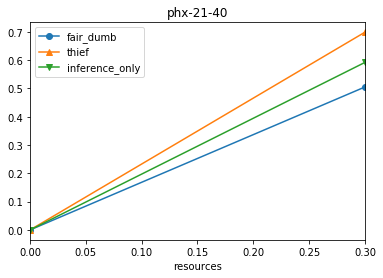

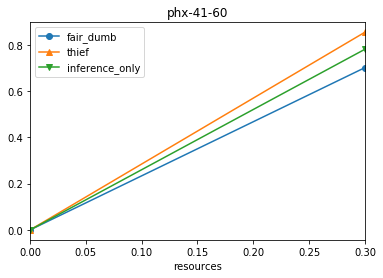

In [56]:
# Cost vs Resource

cities = d.city.unique()
for city in cities:
    temp_df = d[d['city']==city]
    ax = temp_df.plot(x='resources', y=scheds, kind='line',
                        title=city,
                        legend=True, style=['o-', '^-', 'v-'])

In [57]:
d

,city,period,resources,use_oracle,fair_dumb,thief,inference_only
1,phx-21-40,100,0.0,False,0.000000,0.000000,0.000000
3,phx-21-40,100,0.3,False,0.504749,0.698170,0.591501
5,phx-41-60,100,0.0,False,0.000000,0.000000,0.000000
7,phx-41-60,100,0.3,False,0.700924,0.853869,0.780291


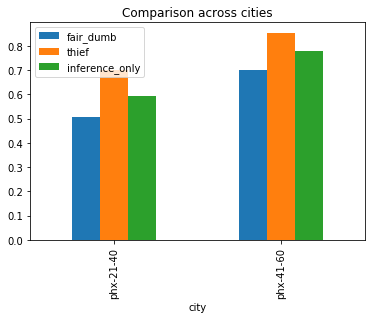

In [66]:
# Comparison across cameras
COMPARE_RES = 0.3
ax = d[d['resources']==COMPARE_RES].plot(x='city', y=scheds, kind='bar',
                  title="Comparison across cities")